Project for the course in OSE-Scientific Computing | Winter 21/22, M.Sc. Economics, Bonn University |
<br><br>
the project is created by:<br><br>
[Daniel Nogues Kollert](https://github.com/johqniel) and [Michael Hannes Gerards](https://github.com/MichaelGds) (Student-ID: 3175485)

________

# Benchmarking Global Optimization Algorithms 

___

This notebook is inpired to a great extent by the following Articles:

> Arnoud, Antoine and Guvenen, Fatih and Kleineberg, Tatjana, Benchmarking Global Optimizers (October 2019)<br><br>

> Beiranvand, V., Hare, W. & Lucet, Y. Best practices for comparing optimization algorithms. Optim Eng 18, 815–848 (2017)<br><br>

> Bartz-Beielstein, T. et al. Benchmarking in Optimization: Best Practice and Open Issues

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Benchmarking-Global-Optimization-Algorithms" data-toc-modified-id="Benchmarking-Global-Optimization-Algorithms-1">Benchmarking Global Optimization Algorithms</a></span></li><li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-2">1. Introduction</a></span></li><li><span><a href="#2.-Global-Optimization" data-toc-modified-id="2.-Global-Optimization-3">2. Global Optimization</a></span></li><li><span><a href="#3.-Optimization-Algorithms" data-toc-modified-id="3.-Optimization-Algorithms-4">3. Optimization Algorithms</a></span><ul class="toc-item"><li><span><a href="#3.1-Gradient-Based-Algorithms" data-toc-modified-id="3.1-Gradient-Based-Algorithms-4.1">3.1 Gradient Based Algorithms</a></span></li><li><span><a href="#3.2-Derivative-Free-Algorithms" data-toc-modified-id="3.2-Derivative-Free-Algorithms-4.2">3.2 Derivative-Free Algorithms</a></span></li><li><span><a href="#3.3-Algorithms-Considered-and-Algorithm-Configuration" data-toc-modified-id="3.3-Algorithms-Considered-and-Algorithm-Configuration-4.3">3.3 Algorithms Considered and Algorithm Configuration</a></span></li></ul></li><li><span><a href="#4.-Test-Problems" data-toc-modified-id="4.-Test-Problems-5">4. Test Problems</a></span><ul class="toc-item"><li><span><a href="#4.1-Griewank-Function" data-toc-modified-id="4.1-Griewank-Function-5.1">4.1 Griewank Function</a></span></li><li><span><a href="#4.2-Rastrigin-Function" data-toc-modified-id="4.2-Rastrigin-Function-5.2">4.2 Rastrigin Function</a></span></li><li><span><a href="#4.3-Levi-Function" data-toc-modified-id="4.3-Levi-Function-5.3">4.3 Levi Function</a></span></li><li><span><a href="#4.4-Rosenbrock-Function" data-toc-modified-id="4.4-Rosenbrock-Function-5.4">4.4 Rosenbrock Function</a></span></li></ul></li><li><span><a href="#5.-Benchmarking-Procedure" data-toc-modified-id="5.-Benchmarking-Procedure-6">5. Benchmarking Procedure</a></span><ul class="toc-item"><li><span><a href="#5.1-Performing-Benchmarking-Experiments" data-toc-modified-id="5.1-Performing-Benchmarking-Experiments-6.1">5.1 Performing Benchmarking Experiments</a></span></li><li><span><a href="#5.2-Algorithm-Performance-Measures" data-toc-modified-id="5.2-Algorithm-Performance-Measures-6.2">5.2 Algorithm Performance Measures</a></span></li><li><span><a href="#5.3-Reporting-Results" data-toc-modified-id="5.3-Reporting-Results-6.3">5.3 Reporting Results</a></span></li><li><span><a href="#5.3-Specific-Approach-of-this-Study" data-toc-modified-id="5.3-Specific-Approach-of-this-Study-6.4">5.3 Specific Approach of this Study</a></span></li></ul></li><li><span><a href="#6.-Results" data-toc-modified-id="6.-Results-7">6. Results</a></span><ul class="toc-item"><li><span><a href="#6.1-Griewank-Function" data-toc-modified-id="6.1-Griewank-Function-7.1">6.1 Griewank Function</a></span><ul class="toc-item"><li><span><a href="#6.1.1-Data-Profiles" data-toc-modified-id="6.1.1-Data-Profiles-7.1.1">6.1.1 Data-Profiles</a></span></li><li><span><a href="#6.1.2-Deviation-Profiles" data-toc-modified-id="6.1.2-Deviation-Profiles-7.1.2">6.1.2 Deviation-Profiles</a></span></li></ul></li><li><span><a href="#6.2-Rastrigin-Function" data-toc-modified-id="6.2-Rastrigin-Function-7.2">6.2 Rastrigin Function</a></span><ul class="toc-item"><li><span><a href="#6.2.1-Data-Profiles" data-toc-modified-id="6.2.1-Data-Profiles-7.2.1">6.2.1 Data-Profiles</a></span></li><li><span><a href="#6.2.2-Deviation-Profiles" data-toc-modified-id="6.2.2-Deviation-Profiles-7.2.2">6.2.2 Deviation-Profiles</a></span></li></ul></li><li><span><a href="#6.3-Levi-Function" data-toc-modified-id="6.3-Levi-Function-7.3">6.3 Levi Function</a></span><ul class="toc-item"><li><span><a href="#6.3.1-Data-Profiles" data-toc-modified-id="6.3.1-Data-Profiles-7.3.1">6.3.1 Data-Profiles</a></span></li><li><span><a href="#6.3.2-Deviation-Profiles" data-toc-modified-id="6.3.2-Deviation-Profiles-7.3.2">6.3.2 Deviation-Profiles</a></span></li></ul></li><li><span><a href="#6.4-Rosenbrock-Function" data-toc-modified-id="6.4-Rosenbrock-Function-7.4">6.4 Rosenbrock Function</a></span><ul class="toc-item"><li><span><a href="#6.4.1-Data-Profiles" data-toc-modified-id="6.4.1-Data-Profiles-7.4.1">6.4.1 Data-Profiles</a></span></li><li><span><a href="#6.4.2-Deviation-Profiles" data-toc-modified-id="6.4.2-Deviation-Profiles-7.4.2">6.4.2 Deviation-Profiles</a></span></li></ul></li><li><span><a href="#6.5-Performance-Profiles" data-toc-modified-id="6.5-Performance-Profiles-7.5">6.5 Performance Profiles</a></span></li></ul></li><li><span><a href="#7.-Extension-of-the-Suite-of-Test-Problems" data-toc-modified-id="7.-Extension-of-the-Suite-of-Test-Problems-8">7. Extension of the Suite of Test Problems</a></span></li><li><span><a href="#7.1-Ackley-Function" data-toc-modified-id="7.1-Ackley-Function-9">7.1 Ackley Function</a></span><ul class="toc-item"><li><span><a href="#7.1.1-Data-Profiles" data-toc-modified-id="7.1.1-Data-Profiles-9.1">7.1.1 Data Profiles</a></span></li><li><span><a href="#7.1.1-Deviation-Profiles" data-toc-modified-id="7.1.1-Deviation-Profiles-9.2">7.1.1 Deviation Profiles</a></span></li></ul></li><li><span><a href="#7.2-Zakharov-Function" data-toc-modified-id="7.2-Zakharov-Function-10">7.2 Zakharov Function</a></span></li><li><span><a href="#7.2.2-Data-Profiles" data-toc-modified-id="7.2.2-Data-Profiles-11">7.2.2 Data-Profiles</a></span></li><li><span><a href="#7.2.3-Deviation-Profiles" data-toc-modified-id="7.2.3-Deviation-Profiles-12">7.2.3 Deviation-Profiles</a></span></li><li><span><a href="#7.2-Easom-Function" data-toc-modified-id="7.2-Easom-Function-13">7.2 Easom Function</a></span></li><li><span><a href="#8.-Extension:-Economic-Application" data-toc-modified-id="8.-Extension:-Economic-Application-14">8. Extension: Economic Application</a></span><ul class="toc-item"><li><span><a href="#7.1-Results" data-toc-modified-id="7.1-Results-14.1">7.1 Results</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-15">References</a></span></li></ul></div>

In [2]:
from numpy import *
import pandas as pd
import random
import nlopt
import numpy as np
import matplotlib.pyplot as plt
import numbers
import math
import seaborn as sns
import autograd.numpy as ag
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
from numpy.lib.function_base import vectorize
from autograd import value_and_grad
np.set_printoptions(precision=20)
pd.set_option("display.precision", 14)
from auxiliary.test_functions_daniel_copy import *
from auxiliary.testing_daniel_copy import *
from auxiliary.functions_daniel_copy import *
from auxiliary.aux_m.optimization_function_nlopt import *
from auxiliary.aux_m.test_problems_info import *
from auxiliary.aux_m.test_problems import *
import warnings
warnings.filterwarnings('ignore')

---
# 1. Introduction 
---

In this project we conduct a benchmarking exercise in which we benchmark multiple optimization algorithms of the **NLOPT** library. We evaluate the performance of these optimizers and compare them on challenging multidimensional test functions. The benchmarking approach of this study follows in great parts the methodology outlined in Guvenen et al. (2019). The findings of this project indicate that the performance of these optimization algorithms varies throughout the entire set of test problems. The performance is as expected largely dependent on the nature of the test problem (e.g. deep ridges, valley shaped, many local minima etc.) and the computational budget available. The computational budget is measured as number of objective function evaluations in our project. Throughout this study we present **Data-Profiles**, **Deviation-Profiles** and **Performance-Profiles**. Additionally we implemented two other algorithms by ourselfes. One algorithm besed on **Newtons root finding method** and the **Nelder-Mead Optimization Algorithm**. This project finishes with an application to an empirical example in economic sciences. We apply these algorithms in order to solve a **Markowitz Mean Variance** optimization problem.

---
# 2. Global Optimization 
---

A general problem formulation for global optimization can be found for example in Pardalos and Romeijn (2013), where $x^*$ is the optimizer that solves the following general continous global optimization problem:<br>

\begin{align*}
        &\min_x\space\textbf{f(x)}\\  
        &\text{s.t.}\space g_j(x)\leq0\space \text{for all } j=1,...,\mathcal{J} ,\\
        &\text{and } \space x\in \textbf{X}.\\
\end{align*}

Where $\textbf{X}\subseteq\mathbb{R}^n$ is a convex closed set. This optimization problem has a total of $\mathcal{J}$ constraints.<br><br>The optimizer $x^*$ is a vector of dimension $\textbf{n}$ and can be written as $x^*=(x_1,x_2,...,x_n)^T$ and the $x_i$'s can be called decision variables (see Pardalos & Romeijn, 2013).<br>
According to Liberti (2008) the continous global optimization problem (CGOP) is formulated in terms of finding the point $x$ in a solution space set $\textbf{S}$ which is also called the feasible region. The feasible region $\textbf{S}$ is a non-empty set of feasible decisions (see Pardalos and Romeijn, 2013:517). The general objective is to find $x\in S$ where the objective function $f:X\rightarrow T$ attains a minimum. $T$ can be any ordered set, and is usually a subset of $\mathbb{R}$.<br> A central assumption is that the function we want to optimize is assumed to be a continuous objective function. The feasible set $\textbf{S}$ is usually a proper subset of of $\mathbb{R}^n$ defined by the $\mathcal{J}$ constraints: 
    
$$g_j(x)\leq0 \text{ for all }j \in \{j=1,2,3,....,\mathcal{J}\}.$$ 

So we have a set of $\mathcal{J}$ possibly nonlinear functions of $x$ as constraints. To be more precise $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$ is a finite collection ($\mathcal{J}$ vector) of continous constraint functions (see Pardalos & Romeijn, 2013). The primary goal is to minimize the n-dimensional function $\textbf{f}:\mathbb{R}^n\rightarrow \mathbb{R}$ subject to the $\mathcal{J}$ constraints and subject to $x\in S$. So we can formulate the general continous global optimization problem (CGOP) as:

\begin{align*}
        &\min_x
        \space\textbf{f(x)}\\
        &s.t.\space x\in \textbf{S}\coloneqq \{x \in \textbf{X}|\space g_j(x)\leq0\space j=1,\dots,\mathcal{J}\}
\end{align*}

The global optimizer, $x^*$ solves the optimization problem shown above and has the following properties (definition of a global minimum):

$$  f(x^*)\leq f(x) \space \forall \space x \in S.$$
    
This definition also allows for multiple global minima. Because not all functions have a unique multiple minimum, this definition specifies the points that are global minima in case of multiple global minima. As some  of the algorithms use local optimization algorithms we provide the definition of a local optimum:

$\tilde{x}\in S$ is called a local minimum of the function $f(x)$ in some neighbourhood $U$ around $\tilde{x}$ if the following holds:

\begin{align*}
        f(\tilde{x})\leq f(x)\space\space \forall x\in U\cap S.
\end{align*}

In our project we will mostly perform unconstrained global optimization. We will in most cases optimize a test function within the domain $D$ of this test function. Which is in turn a constrained optimization with $n$ constraints as shown below:

\begin{align*}
    \min_x
    \space\textbf{f(x)}\\
    s.t.\space x\in \textbf{D}.\\
\end{align*}

We can see that the $n$ constraints as well as the $n$ decision variables must lie within the domain specified in $D$. In this domain the variable bounds are specified for each decision variable: 

$$x^L\leq x\leq x^{U}\text{ with }x^L,x^{U}\in\mathbb{R}^n.$$ 

Thus we can write the optimization program performed in most cases in our study as follows:

\begin{align*}
        &\min_x\space\textbf{f(x)}\\
        &s.t.\space x^L\leq x\leq x^U.
\end{align*}

---
# 3. Optimization Algorithms
---

In this chapter we list the optimization algorithms we will consider in our study and explain selected ones. From now on we will refer to the optimization algorithm based on the Newton method as the $\textit{Newton Optimization}$. We implemented the Newton optimization algorithm and the Nelder Mead simplex algorithm. Although we know that the Nelder Mead simplex Method is already well explored and implemented in numerous packages within the python landscape, we had a interest in implementing this specific method by ourself, since it is particulary easy to implement and fast. In total we will consider 9 optimization algorithms. Most of them are implemented in the **NLOPT-Library**.
The most general way to classify optimization algorithms is to consider two different classes of algorithms, **derivative-free** and **gradient based** optimization algorithms.




---
## 3.1 Gradient Based Algorithms
---

One approach to optimize a function is to use its derivatives. The general idea uses that the gradients of a function $\nabla f (\mathbf{x})$ tell us whether we are moving up or down if we move in the direction of $\mathbf{x}$. We can start at some point $\mathbf{x_n}$ and solve in each iteration for the direction $\mathbf{y}$ with the steepest slope. In our next iteration we then consider $$\mathbf{x_{n+1}}:= \mathbf{x_n} + \epsilon \cdot \mathbf{y},$$ where $\epsilon$ is some small number. Though this approach is very intuitive it comes with a few drawbacks. For example it is not easy to implement and costly since it requieres solving linear equations. Furthermore gradient based routines fail at optimizing discrete functions or functions with discontinuity points. 
One example for a gradient based algorithm is the optimization based on the Newton Method. It is well studied algorithm that works a little different than described above. We will give a detailled describtion later but in short: Using the functions second derivative it finds the derivatives roots which are the local minima and thus potential global minima. The algorithm **Newton NAIVE Algorithm** implemented by ourselves is the only gradient based algorithm considered throughout our study. All other algorithms are derivative free algorithms.

---
## 3.2 Derivative-Free Algorithms
---

As the name suggest this class comprises all sorts of optimization algorithms that do not use derivatives of the function to be optimized. It is difficult to give an general idea how it works, since there are many different approaches. An interesting pattern is that often times these algorithms are inspired by nature or other real life phenomena. For example there is an optimization algorithm inspired by imperialistic competition (E. Atashpaz-Gargari and C. Lucas, 2007) and discrete optimization algorithms inspired by the behaviour of bees (D.T. Pham, 2005) and ants (A. Colorni, M. Dorigo and V. Maniezzo 1991).

A well known gradient free algorithm for non discrete functions is the nelder-mead algorithm. It simulates a simplex that moves around the graph of the function until it finds a candidate for a global optimum. We are going to give a more detailed description in the following chapter.

Explaining all different kinds of algorithms would go far beyond the scope of this project. However I would like to sketch in a more generalistic way how algorithms of the class "evolution startegy algorithms" work, because two algorithms ESCH and ISRES are evolution strategy algorithms.<br> Evolution Strategy algorithms are based on the evolution of a population (set of individuals) along generations (see Guvenen et al., 2019). The population can be divided in two distinct groups, $\mu$ "parents" and $\lambda$ "offsprings". Each generation undergoes then a change in population size, the population is extended to $\mu+\lambda$ individuals. Then the algorithm specific selection process reduces the population size again to $\mu$ individuals. Evolution Strategy algorithms differ in the way how they generate the "offspring" individuals and how the selection of individuals of the set $\mu+\lambda$ is made. Or in other words: how "surviving individuals" are selected.<br>
The basic structure of a $(\mu+\lambda)$ Evolution Strategy algorithm can be inferred from Guvenen et al. (2019):<br><br>
**1.Initalize**<br><br>
The algorithm generates $\lambda$ individuals $(x_i',\sigma_i')$. The points $x_i'$ are uniformly and randomly chosen from the search space $X$. $\sigma_{i,j}$ is a measure that generates a specific point within the search space of dimension $j$: \begin{align}\sigma_{i,j}=\frac{\overline{x}_j-\underline{x}_j}{\sqrt{n}}\end{align} where n is the number of dimensions of the objective function, and $\overline{x}_j$ and $\underline{x}_j$ are the upper and lower bounds of the search space of dimension $j$.<br><br>
**2. Ranking**<br><br>
Then the algorithm ranks the $\lambda$ points which were generated from best $x_b$ to worst $x_w$. The best point is characterized as the point with the smallest function value $f(x_b)$. The algorithm then keeps the best $\mu$ individuals $(x_i,\sigma_i)$, $i\in\{1,...,\mu\}$.<br><br>
**3.Replication**<br><br>
A new population of $\lambda$ individuals is generated by a algorithm specific rule (algorithm specific).<br><br>
**4.Repetition**<br><br>
Steps 1 to 3 are repeated until a stopping criterion is met.



---
## 3.3 Algorithms Considered and Algorithm Configuration
---

In our benchmarking analysis we considered in total **eight** different global optimization algorithms. For now we excluded the two algorithms written by ourselfes: **Nelder Mead Simplex** and the **Naive Newton Optimization Algorithm**. They were still not fast efficient enough to finish in a reasonable time. The algorithms under consideration are **ISRES (Improved Stochastic Ranking Strategy)**, **Controlled Random Search (CRS)**, **ESCH (Evolutionary Algorithm)**, **Nelder-Mead-Simplex Algorithm**, a **NAIVE Newton Optimization Algorithm** and five different variants of the **Multi-Level Single Linkage Algorithm**. I will briefly sketch the nature of each algorithm and mention in detail the algorithm configuration we chose. A detailed and comprehensible explanation of the NLOPT-algorithms is provided in the online appendix in Guvenen et al. (2019). The tolerances chosen for convergence in function value and x-value for the global optimization routine will be explained in the next section.

**Newton Optimization Algorithm**

We designed and implemented a naive optimization algorithm that uses the Newton-method. It is far from perfect and comes with many flaws but it is a good object to test how well sophisticated optimization algorithms perform compared to a self made version. As mentioned above the Newton-method is a routine that finds roots of continously differential functions. We know from basic analysis that a differentiable function has a local optimum **iff** its derivative is zero at that point. If we apply the Newton-method to the derivative of a function we thus get a local extremum. Assuming that the function we are looking at is bounded from below we know that the global minimum is also a local minimum. If the function has only one local extremum this will also be the global minimum and our routine would give us the desired result. Since a function can have many local extremums and saddlepoints we run the newton method from multiple starting points and pick the best one as our guess for the global minimum.

Clealry this are many "if's" and its easy to think about functions that would make it really hard for our algorithm to find the right optimum. For example it can not distinguish between local minima and maxima, which makes it a very weak tool for optimizing a function with many local minima and maxima. Thus we do expect this algorithm to perfom very poorly in the success rate  


**NELDER-MEAD SIMPLEX ALGORITHM**

The Nelder-Mead-method (Nelder, Mead 1965) is the second optimization algorithm that we implemented ourselfes. It generated a simplex around the starting point and then checks how its verticies are horizontally distributed on the surface of the function to be optimized. Depending on how they are the simplex wanders arounds the function by reflecting its highest verticy contracting the highest verticy inside of the simplex or shrinking the whole symplex towards the lowest verticy of the symplex.



**CONTROLLED RANDOM SEARCH**<br><br>
Controlled Random Search algorithms were first introduced by Price (1977). The variant used in our benchmarking study is called $\textit{Controlled Random Search two with local mutation}$ **(CRS2-LM)** which can be found in Kaelo and Ali (2006). Controlled Random Search algorithms are direct search algorithms.   
Additionally the Controlled Random Search **(CRS)** algorithm has a common feature with so called genetic algorithms. CRS starts with a random "population" of points and evolves these randomly generated points by heuristic rules. In case of Controlled random search the "evolution" is based on a randomized version of the Nelder-Mead algorithm. A great advantage of controlled random search algorithms is that they do not require a great knowledge about the properties of the objective function (e.g. differentiability) (see. Guvenen et al., 2019).  We choose the standard configuration of this algorithm provided by the NLOPT library.

**ISRES (Improved Stochastic Ranking Evolution Strategy)**

ISRES is a population based algorithm within the NLOPT library, so we can say that ISRES is a evolutionary algorithm. Consequently this algorithm falls in the class of stochastic search algorithms. Evolutionary algorithms are based on the evolution of a population (a set of individuals) along generations (see Guvenen et al.,2019). Guvenen et al. (2019) explain evolutionary algorithms in the following way: the population is composed of two groups: $\mu$ parents and $\lambda$ offsprings. During each generation, the population size changes from $\mu$ to $\mu+\lambda$ individuals. Then the algorithm selects individuals, and the population collapses again to $\mu$. The variety of different evolutionary algorithms differs in the way how offspring is generated and in the selection of surviving individuals. For our benchmarking exercise the algorithm configuration for the ISRES algorithm sets the population size to the default population size, which is $20\times(n+1)$ where n is the number of dimensions of the objective function. The algorithm is based on the work of Runarsson and Yao (2000).

**MLSL (Multi-Level Single-Linkage)**

MLSL is a "multistart" algorithm. This algorithm does a sequence of local optimizations, and thereby relies on another local optimization algorithm.<br>
The sequence of starting points is generated pseudo-randomly (MLSL) or the starting points can be generated by a Sobol "low-discrepancy" sequence (MLSL-LDS). The original optimization algorithm with pseudo randomly generated starting points was initially proposed by Rinnooy Kan and Timmer (1987). In total we considered five different versions of this algorithm. Generally we chose two different local optimization algorithms. Nelder Mead and BOBYQA, which are both implemented as local optimization routines within the nlopt library. The first algorithm specification we considered is MLSL with a local optimization routine performed by **NELDER MEAD**. Two versions of this specifications are considered, the first sets the local tolerance for convergence in x value to $\frac{1}{10^3}$ and the local tolerance for convergence in function value to $\frac{1}{10^3}$. The other algorithm specification sets the local tolerance for convergence in x value to $\frac{1}{10^8}$ and the local tolerance for convergence in function value to $\frac{1}{10^8}$. Another way would be to set the local tolerance for convergence in function value to $\infty$. By setting the local tolerance for convergence in function value to $\infty$ we "force" the local search algorithm to search until the local criterion for convergence in x-value is met. Within the NLOPT library you can specify multiple stopping criteria, the optimization terminates then the optimization routine whenever one criterion is met. Setting the local tolerance for convergence in function value to infinity implies a granular local search in the whole search space. In our specification the local search algorithm terminates the search whenever the first "stopping criterion" is met. In many cases with multiple stopping criteria the optimization is terminated when the tolerance for convergence in the function value is reached, however often the returned optimizer $x$ is then often "imprecise" as he does not met the desired tolerance for convergence in $x$ value. This setting may imply a more detailed local search for convergence in parameter vector $x$ but it also increases computing time.<bR>
The second algorithm specification is based on MLSL but now the local optimization routine is the **BOBYQA** algorithm. Again we choose two different local tolerances for convergence in x-value $\frac{1}{10^3}$ and $\frac{1}{10^8}$ the local tolerances for convergence in function values will be $\frac{1}{10^3}$ and $\frac{1}{10^8}$ respectively.<br>
The last algorithm specification is based on MLSL-LDS and chooses **NELDER MEAD** as local optimization algorithm. We set the local tolerance for convergence in $x$-value to $\frac{1}{10^8}$ and the local tolerance for convergence in function value to $\frac{1}{10^8}$.
    
**ESCH (Evolutionary Strategy with Cauchy Distribution)**
    
ESCH is an evolutionary algorithm. It was originally proposed by Silva-Santos et al. (2010). ESCH is based on a $\mu+\lambda$ evolution strategy algorithm. This algorithm creates an initial population that is then iteratively recombined according to a single point recombination (see Guvenen et al.,2019). Additionally the individuals undergo mutations generated by a Cauchy distribution. At each generation, the best $\mu$ individuals are selected from the entire population ($\mu+\lambda$). This algorithm will be used in its default specification provided by the NLOPT library.







---
# 4. Test Problems
---

For the benchmarking analysis our structure follows the structure proposed by Guvenen et al. We will also select the four test functions named: <br>

- Griewank Function (10 dimensions)
- Rastrigin Function (10 dimensions)
- Levi No. 13 Function (10 Dimensions)
- Rosenbrock Function (10 dimensions)

<br> The test problems above are considered to be among the most challenging for global optimization algorithms (see Ali et al. (2005)). The Rastrigin function and Levi No. 13 Function both have many local minima, whereas the Rosenbrock function is a valley shaped function. Each function exhibits a combination of challenging features, such as a large number of local minima, deep ridges or very flat valleys where algorithms can get stuck. A general reference for a well organized library of test problems, for the purpose of benchmarking optimization algorithms, is given by this Website [test problem library](https://www.sfu.ca/~ssurjano/optimization.html) (Surjanovic & Bingham, 2013) or Jamil and Yang (2013). The following subsections introduce the different test problems shown above. One advantage of the four test problems is that these test problems are well defined for any number of dimensions. We will show benchmarking results for **n=10** (10 dimensional functions). The first three test functions display a large number of local minima, whereas the fourth one, is "valley-shaped" and therefore has a very flat surface near the global minimum (see Guvenen et al. 2019).

---
## 4.1 Griewank Function
---

The Griewank function, first introduced by Griewank (1981) has been employed as test function for global optimization algorithms in many papers.<br>
The Griewank Function in n- dimensions is defined by the following expression:<br><br>
\begin{align*}
    f(x)=\sum_{i=1}^n\frac{x_i^2}{a}-\prod_{i=1}^n\cos(\frac{x_i}{\sqrt{i}})+2.
\end{align*}
Where $n$ is the number of dimensions. We will choose $a=200$ as described in Guvenen et al. (2019). Alternatively the standard parameter specification for the parameter is $a=4000$ as in Surjanovic and Bingham (2013) and Jamil and Yang (2003). The Griewank function has many widespread local minima, which have a regular distribution along the domain. The complexity is shown in the following plot. The domain of interest is defined by the hypercube $x\in[-100,100]^n$. The global minimum of this function is at $x=(0,...,0)$ with function value $f(0,...,0)=1$. We have plotted the Griewank function for $n=2$ (two dimensional function):

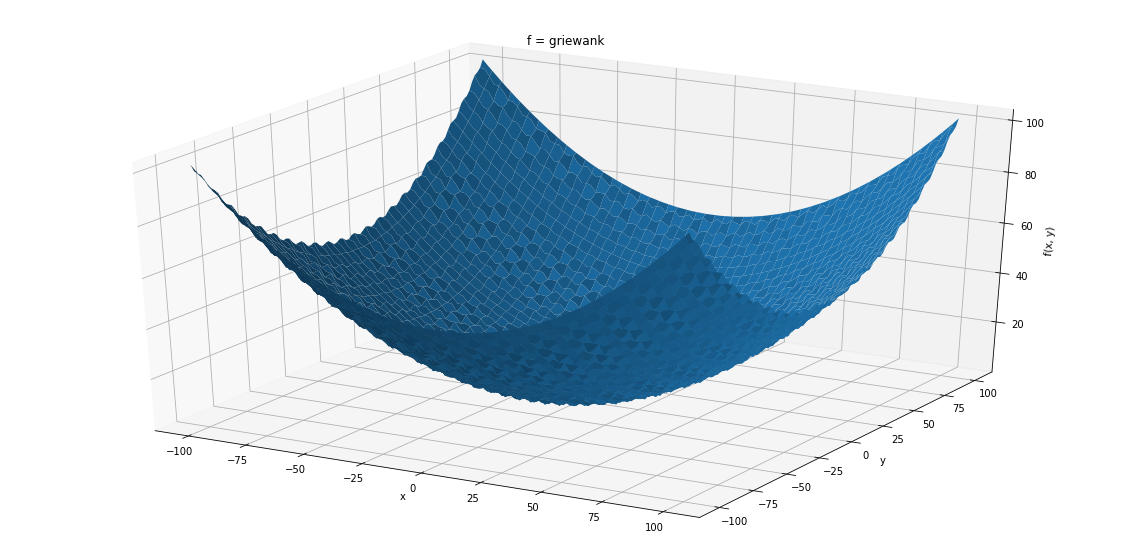

In [2]:
plot_test_function((-100,100),griewank, 'griewank')

The Griewank function has the shape of a "bowl" which is due to the first term of the function, which is quadratic. The Griewank function can be nataturally split in two parts according to Locatelli (2003)(modified for our purpose):<br><br>
\begin{align*}
Griewank_n(x)=f_n(x)+h_n(x)+2
\end{align*}S
where $f_n(x)=\sum_{i=1}^n\frac{x_i^2}{a}$ is a quadratic convex function, whose local (and global) minima are located in the origin (the same position of the global minimum of the whole Griewank function), while 

$$h_n(x)=-\prod_{i=1}^n\cos(\frac{x_i}{\sqrt{i}})$$ 

is an oscillatory nonconvex function. Basically the oscillations introduced by function $h_n$ are superimposed over the function $f_n$ and give rise to the large number of local minima. The figure below displays the contour of the griewank function on the domain $x \in [-50,50]^2$.

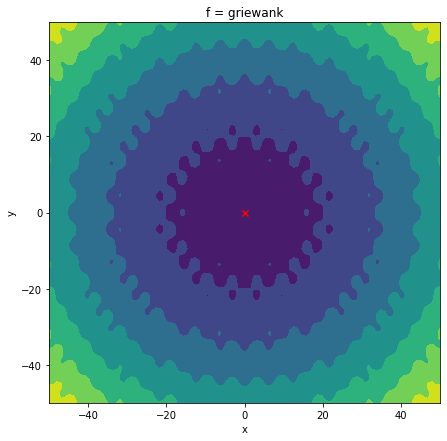

In [3]:
plot_test_function_contour((-50,50),griewank,'griewank',opt=(0,0))

The second contour plot, shows the griewank test function an a smaller domain $x\in [-25,25]^2$, where we can clearly see that the griewank function has many local minima, because any closed circle on the contour map contains at least one local minimum.

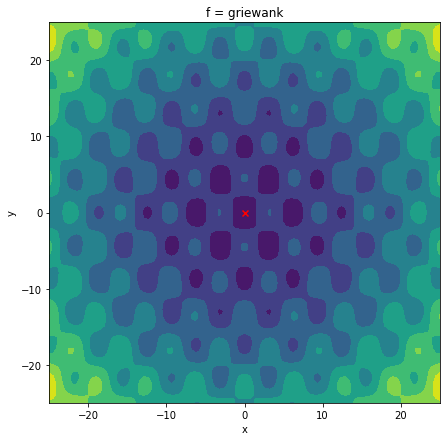

In [4]:
plot_test_function_contour((-25,25),griewank,'griewank',opt=(0,0))

---
## 4.2 Rastrigin Function
---

The general definition of the Rastrigin function can be found in Surjanovic and Bingham (2013):<br>
\begin{align*}
f(x)=An+\sum_{i=1}^n[x_i^2-A\cos(2\pi x_i)],
\end{align*}
where A=10 is a constant and $n$ is the number of dimensions. The rastrigin function is a non-linear highly multimodal function but the location of local mimima follows a regular pattern. We will evaluate the Rastrigin function based on the functional form proposed by Guvenen et al. (2019):

\begin{align*}
    f(x)=An+\sum_{i=1}^n[x_i^2-A\cos(2\pi x_i)]+1.
\end{align*}

Similarly we will choose A=10 and will focus on the domain that is usually evaluated in benchmarking experiments $x\in [-5.12,5.12]^n$. The global minimum is located at $x=(0,...,0)$ with function value $f(0,...,0)=1$.

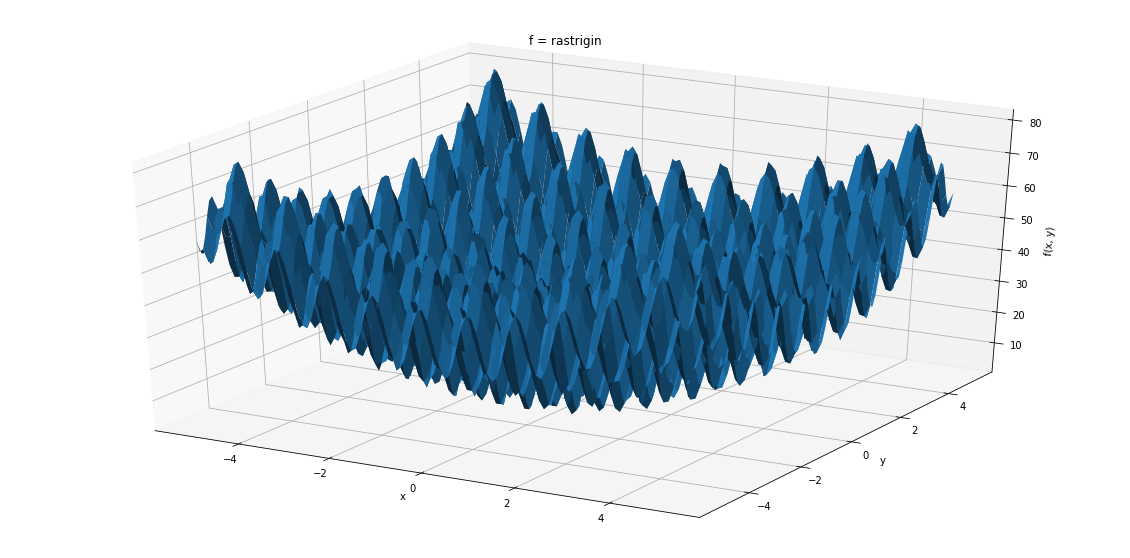

In [3]:
plot_test_function((-5.12,5.12),rastrigin, 'rastrigin')

The contour plot reaffirmes that the rastrigin function has many local minima. Additionally we can see that the three dimensional function plot (**n=2**) shows that the rastrigin function generally has the shape of a bowl, and each local minimum is buried at the bottom of the bowl (see Guvenen et al. 2019).

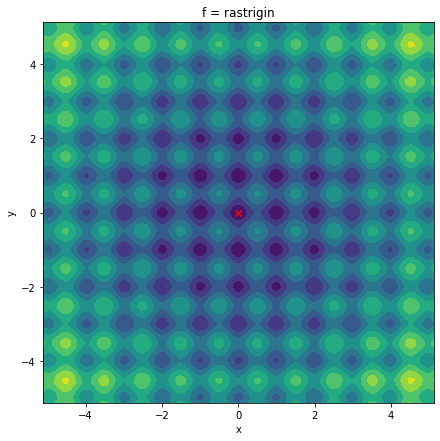

In [6]:
plot_test_function_contour((-5.12,5.12),rastrigin, 'rastrigin',opt=(0,0))

---
## 4.3 Levi Function
---

There exist many different variants of the general Levy-function. The version used in Guvenen et al.(2019) is called "Levi No. 13". The function as proposed in Guvenen et al. (2019) is specified by this term:
\begin{align*}
    f(x)=sin^2(3\pi x_1)+(x_n-1)^2[1+sin^2(2\pi x_n)]+\sum_{i=1}^{n-1}(x_i-1)^2[1+sin^2(3\pi x_{i+1})]+1.
\end{align*}

The domain of interest is usually $x\in [-10,10]^n$. The global minimum is located at $x=(1,...,1)$ with function value $f(1,...,1)=1$. The graph below shows the Levi No. 13 functions for $n=2$. The function is globally bowl shaped. It has a large number of deep ridges that run along the y-direction. Each ridge has a well defined local minimum.

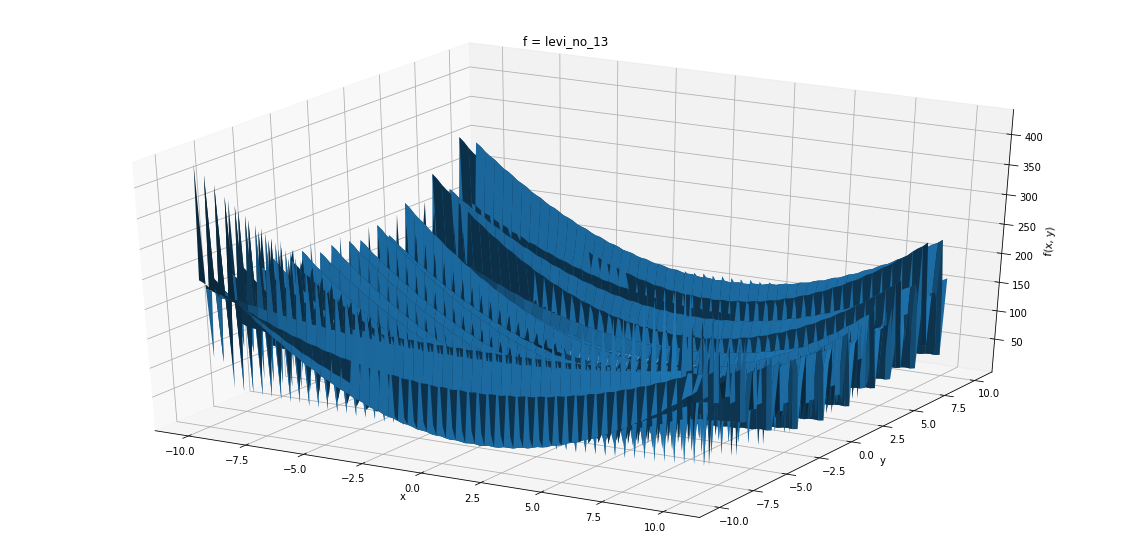

In [4]:
plot_test_function((-10,10),levi_no_13, 'levi_no_13')

The ridges are also visible in the contour map shown below. The function value changes sharply from the sides of the ridge to the bottom. In the middle there is a blue circle where the global minimum is located. The function becomes flatter in that region which complicates the task of finding the minimum.

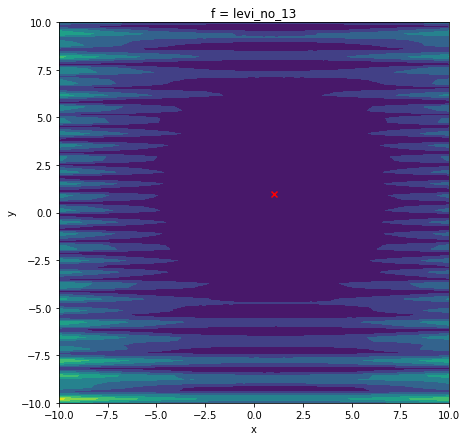

In [10]:
plot_test_function_contour((-10,10),levi_no_13, 'levi_no_13',opt=(1,1))

The version that will be used for our benchmarking exercise will be the "general" levy function as specified by Surjanovic and Bingham (2013). This version is also generalized on $n$ dimensions. I will now specify the formula and global optimum of this function. The function is defined by the following function:

\begin{align*}
    f(x)=\sin^2(\pi w_1)+\sum_{i=1}^{n-1}(w_i-1)^2[1+10\sin^2(\pi w_i+1)]+(w_n-1)^2[1+sin^2(2\pi w_n)],
\end{align*}

with $w_i$ defined as:

\begin{align}
    w_i=1+\frac{x_i-1}{4}.
\end{align}

The global optimum of this function is $x^*=(1,...,1)$ with function value $f(x^*)=0$. This function is evaluated on the hypercube $x_i\in[-10,10]$ for all $i=1,...,n$. This function poses similar challenges towards the optimization algorithms as the "Levi No. 13" function as it has several local minima too.

---
## 4.4 Rosenbrock Function
---

The Rosenbrock function in $n$-dimensions is defined as
\begin{align*}
f(x)=\sum_{i=1}^{n-1}[100(x_{i+1}-x_i^2)^2+(1-x_i)^2]+1,
\end{align*}
where we only consider the domain $x\in[-100,100]^n$. The global minimum is given by $x=(1,...,1)$ with function value $f(1,...,1)=1$. The figure below depicts the rosenbrock function for $n=2$. The function is unimodal and has a flat long valley that contains the global optimum. A danger for the optimization routine would be that the algorithm could get lost in the flat valley that sourrounds the global optimum.

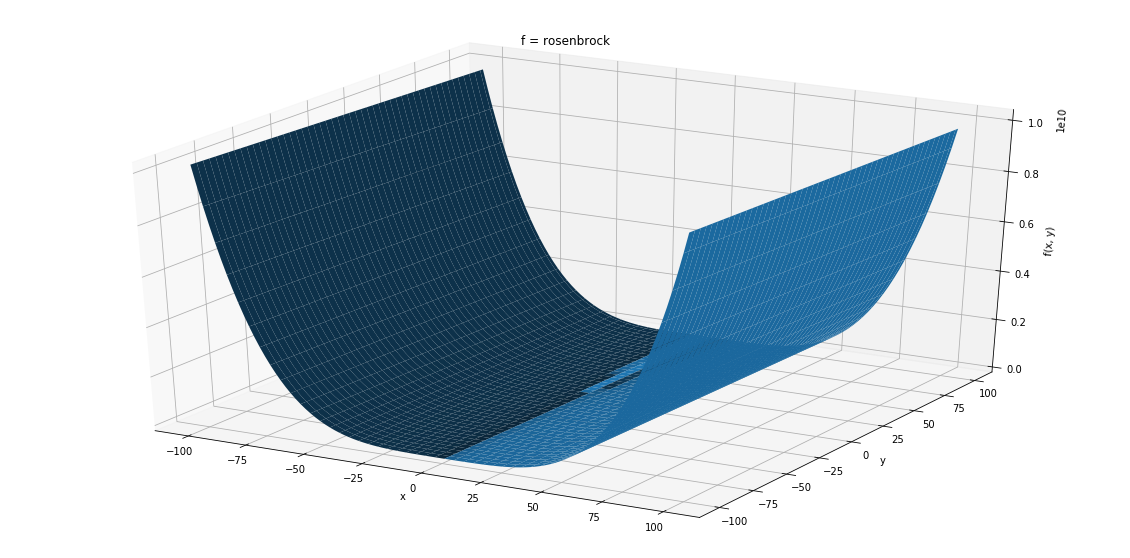

In [5]:
plot_test_function((-100,100),rosenbrock, 'rosenbrock')

The contour plot below plots the contour of the Rosenbrock function closely around the global minimum.

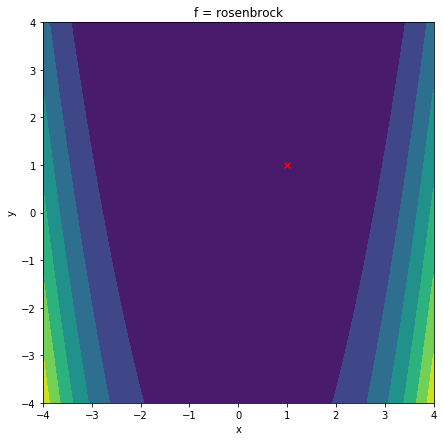

In [7]:
plot_test_function_contour((-4,4),rosenbrock, 'rosenbrock',opt=(1,1))

---
# 5. Benchmarking Procedure
---

Most benchmarking studies have a clear underlying reason, why the study is conducted. For example in Guvenen et al. (2019) the reason for benchmarking has been the introduction of a new optimization routine (the TIK TAK) algorithm. The primary goal of this study has been to show the value of this novel algorithm compared to more classical methods. Other reasons to conduct a benchmarking study are:<br>

- the search for the best algorithm for working with a real world problem
- to compare a new version of an algorithm with prior releases
- to evaluate the performance of an algorithm when different option settings are used (see Beiranvand et al., 2017)

In order to sum up all motives for benchmarking exercises: in any case the researcher wants to gather information about different optimization algorithms in order to rank these algorithms in a certain context. We simply want to gather information about a specific set of optimization algorithms, in order to provide an overview under which test problems a optimization routine is proven to be very efficient or very reliable in solving the test problem. We also acknowledge that our benchmarking results are bound to the algorithm specific configurations we chose as in any benchmarking exercise. However we want to give an overview on how well the algorithms we consider perform on different test problems. 

---
## 5.1 Performing Benchmarking Experiments
---

**Optimization benchmarking** seeks to measure the algorithmic factors (see Beiranvand et al., 2017). To compare algorithms, it is necessary to collect data that measures the overall performance of each algorithm. This is done by running the algorithm on the test set and collecting data on the results. In general Performance measures fall in 3 categories: efficiency, reliability, and quality of the algorithmic output. The following table provides an overview (see Beiranvand et al. 2017):<br>

|  Performance Category  |Example Criteria  |   |   |   |
|---|---|---|---|---|
|Efficiency  |1. Number of fundamental evaluations <br> 2. Running Time <br> 3.Memory Usage|   |   |   |
|Reliability |1. Success Rate <br> 2. Number of constraint violations <br> 3. Percentage of global solutions found   |   |   |   |
|Quality of solution  |1. Fixed-cost solution result <br> 2.Fixed-target solve time <br> 3. Computational accuracy   |   |   |   |


<br> Because for our project the categories Efficiency and Reliability are the central performance categories we will discuss them more in detail in the following.<br><br>
**Efficiency**<br><br>
The efficiency of an optimization algorithm refers to the computational effort required to obtain a solution. In mathematical programming there are two primary measures of efficiency, the number of **fundamental evaluations** and the **running time** (see Beiranvand et al. 2017). A less common is memory usage. The term fundamental evaluation refers to any subroutine that is called by the algorithm in order to gain fundamental information about the optimization problem (see Beiranvand et al. 2017). The most common example could be the number of **objective function evaluations (FEs)**, which is used by Guvenen et al. (2019) as measure for efficiency, other fundamental evaluations include gradient evaluations, Hessian evaluations or constraint function evaluations (see Beiranvand et al. 2017).
Running time as measure for optimization benchmarking, is usually measured by either CPU time or wall clock time. A big problem regarding this measure of efficiency is reproducibility. Wall clock time is not reproducible or verifiable since it is tied to a specific hardware platform and sofware combination (see Beiranvand et al., 2017). Similar CPU-time is only more or less consistent for the same computer architectures with same operating systems. This is one reason why Guvenen et al. (2019) and many other benchmarking studies do not include running time measures in their study.<br><br>
**Reliability**<br><br>
The reliability of an optimization algorithm is defined as the ability of the algorithm to "perform well" over a wide range of optimization problems (see More', Garbow and Hillström 1981). A common performance measure for Reliability is success rate (see Beiranvand, 2017). The success rate is computed by counting the number of test problems that are successfully solved within a pre- selected tolerance. The criterion for "success" can be the distance between the function value of the optimizer and the function value of the global minimum $\textit{(f-value is the criterion of success)}$, or the distance between the optimizers solution point and the point which is considered to be the global minimum $\textit{(x-value is the criterion of success)}$. These measures are also used by Guvenen et al. (2019) as measure of Reliability.<br><br>
**Robustness**<br><br>
According to Bartz-Beielstein et al. (2020) the performance of algorithms can be biased by the initialization of algorithms with respect to, e.g. their random seeds, the starting points, the sampling strategy, combined with the difficulty of the chosen problem instance. Often the stochastic nature of the algorithms themselves pose a problem towards the aim of ensuring reproducibility. Many sampling-based optimization algorithms are nowadays randomized search heuristics and as such their performances will vary if the experiment is repeated, i.e., if the algorithm is executed again using the same input. Therefore, it is common to use performance metrics that aggregate the results of several (ideally independent) runs to provide reliable estimates of the algorithm performance (see Bartz-Beielstein et al.,2020). Another approach which is based on Beiranvand et al. (2017:10) ensures the robustness of the results shown in a benchmarking study, by conducting multiple algorithm runs on many different starting points. That means a good benchmarking study evaluates the performance of an algorithm based on multiple algorithm runs, each algorithm run is done with another starting point. Guvenen et al. (2019) also pick up this approach. They randomly generate for each test problem 100 starting points (within the domain of interest of the test function) and do 100 algorithm runs on these starting points for each test problem and each algorithm (this will be explained in detail in the following section).

---
## 5.2 Algorithm Performance Measures
---

This section discusses in detail the specific measures which measure the performance of a solver $s\in\mathcal{S}$, where $\mathcal{S}$ is the total set of different solvers (optimization algorithms) considered. We will focus on two notions of performance: reliability and efficiency. According to Guvenen et al. (2019) the reliability of an algorithm measures the success rate, that is, the percentage of problems that the algorithm solves successfully. The efficiency (or speed) of an algorithm measures the computational budget (i.e. the number of objective function evaluations or FEs) that the algorithm requires to reach certain success rates. What follows now is a definition which specifies under which circumstances a solution of solver $s\in S$, is considered to be a successful solution for a given test problem.<br>
The primary goal is to find the true global minimum (**convex optimization**) of the objective function. For standard test problems the true global minima are well known and documented. The evaluation of test functions allows us to quantify the reliability of a global optimization algorithm. However in many real world applications the true global minimum of the objective function is unknown to the researcher.<br>
Let $\mathbf{f(x)}$ denote the objective function we wish to minimize in a given Problem $p$, $x_p^*$ denote the (unique) parameter vector at the global minimum and $y_p^*=f_p(x^*)$ be the minimized function value. Additionally let  $\hat{x}_{s,p}^*$ be the global minimum returned by the solver $s$ and $\hat{y}_{p,s}^*=f(\hat{x}_{s,p}^*)$ the corresponding function value. We will use the same definition regarding the success criteria as shown in Guvenen et al. (2019). They define two different success criteria, one based on discrepancy in function values, the other based on discrepancy in the parameter vector.<br><br>
**F-Val Criterion** <br><br> Optimizer $s\in \mathcal{S}$ solved the problem successfully according the function value  (F-Val) criterion if
\begin{align*}
    |y_p^*-\hat{y}_{p,s}^*|<\tau_f,
    \end{align*}
where $\tau_f$ is the desired tolerance we choose for the global optimization algorithm for convergence in function value (F-Val).<br><br>
**X-Val Criterion** <br><br> Optimizer $s\in \mathcal{S}$ solved the problem successfully according the parameter value  (X-Val) criterion if<br><br>
\begin{align*}
\max|x_p^*-\hat{x}_{p,s}^*|<\tau_x,
\end{align*}
where $\tau_x$ is the desired tolerance we choose for the global optimization algorithm for convergence in x-value (X-VAL / parameter-vector). We will choose $\tau_f=10^{-6}$ and $\tau_x=10^{-4}$  in our benchmarking analysis.  



---
## 5.3 Reporting Results
---

Many benchmarking studies use descriptive statistics $\textit{(for example avergage solving time)}$, to report results of a benchmarking experiment. Basic descriptive statistics provide a good overview, but often a single statistic is based on a sequence of single statistical expressions which are then narrowed down to a single number e.g. by computing the mean of a sequence of statistical results. However some information might get lost, and single measures provide only a little overview about the performance of an optimization method. According to Beiranvand et al. (2017) reporting methods fall into the categories: numerical tables, graphics and performance ration methods. This section will now explain in detail what is meant by performance ratio methods (e.g. performance and data profiles).<br><br>

**Convergence Plots**<br><br>
In a convergence plot for optimal benchmarking the best function value achieved is plotted against some measure of fundamental evaluation (e.g. objective function evaluation). According to Beiranvand et al. (2017) the main drawback of convergence plots for a benchmark, that aggregates the results accross the suite of test problems, is the following: <br><br>

It could be not applicable for this specific benchmarking approach, as convergence plots visualize a optimization method on **one** specific problem. A single convergence plot always plots the convergence results for, e.g. multiple optimization methods on one specific problem. We will not show convergence plots as Guvenen et al. (2019) did not show convergence plots, although it would have been a benefit, because Guvenen et al. (2019) look at each test problem distinctly. They only aggregate data accross different test problems for performance profiles. Another reason why we did not implement convergence plots is that the nlopt implementation in python lacks a so called **verbose** option, that allows to retrieve the best function value achieved by each function evaluation. Though the nlopt library may have this option, we were not able to implement a **verbose** option.

**Data Profile**<br><br>

In general it can be said that data profiles give an answer to the following question: 

\begin{align*}
    \textit{"What percentage of problems can be solved by optimizer }s\textit{ within a fixed budget }\gamma\textit{ (for a given tolerance level)?"}.
\end{align*}

A data profile therefore plots the fraction of test problems a solver solves successfully (for a given success criterion) within the computational budget $\gamma$. The general definition provided by Beiranvand et al. (2017) anticipates that the required number of function evaluations to satisfy the convergence test increases with the dimensionality $n$ of the function. The definition given by Beiranvand et al. (2017) is given by:<br><br>

\begin{align*}
    d_s(\gamma)=\frac{1}{|\mathcal{P}|}size\bigg\{p\in\mathcal{P}:\frac{t_{p,s}}{n_p+1}\leq\gamma\bigg\},
\end{align*}

where $t_p,s$ is the number of function evaluations required to satisfy the convergence test by solver $s$ on problem $p\in\mathcal{P}$ where $|\mathcal{P}|$ is the total number of Problems considered and $\mathcal{P}$ is the set of problems considered. The definition implemented in our code follows the definition of data profiles provided by Guvenen et al. (2019) which is very similar:<br><br>

\begin{align*}
    d_s(\gamma)=\frac{1}{|\mathcal{P}|}size\bigg\{p\in\mathcal{P}:t_{p,s}\leq\gamma\bigg\}.
\end{align*}
Here $\gamma$ is still the fixed budget under consideration (number of objective function evaluations FEs), $t_{p,s}$ is the performance measure. The performance measure $t_{p,s}>0$, is defined as the **number of objective function evaluations (FEs)** that optimizer $s$ needs problem $p$ successfully. Higher values of $t_{p,s}$ imply worse performance. Our python function **success_results_all** does this for all considered algorithms and returns a dataframe with all success probabilities at all computational budgets for all algorithms. It does so, by first dropping all problems for which $t_{p,s}>\gamma$, then we have a subset (this is necessary although we have a stopping criterion based on the maximum number of allowed function evaluations, but some algorithms sometimes exceed this stopping criterion due to their stochastic nature [see NLOPT documentation chapter stopping criteria]). Then this function moves chronologically through all computational budgets considered, and drops all optimizer that not meet the success criterion. Then the number of optimizer that remain is calculated at each budget and divided through the number of Problems considered (number of starting points).


**Performance Profile**<br><br>

Performance profiles (see Dolan and More',(2002) and More' and Wild,(2009)) are an important tool to assess the efficiency and reliability of an optimization algorithm. It allows a direct comparison of optimizers with each other. Performance profiles have emerged as an important tool to compare the performances of optimization algorithms based on the cumulative distribution function of a performance metric (e.g. CPU time, achieved optimum) (see Bartz-Beielstein et al., 2020).<br> Performance profiles provide information such as efficiency, robustness and probability of success in a graphically compact form (see Beiranvand et al.,2017). However performance profiles should not be missunderstood, performance profiles can not be used to infer the percentage of test problems that can be solved within some specific number of function evaluations, because performance profiles are not evaluated against the number of function evaluations (see Bartz-Beielstein et al.,2020). In general it can be said that a performance profile illustrates how the distribution of performance measures of a optimizer compares to those of other optimizers. In the following lines I will provide the definition of a performance profile based on Guvenen et al. (2019): again $\mathcal{P}$ is the set of problems considered and $\mathcal{S}$ is a set of optimization solvers considered. Performance profiles are now defined in terms of a performance measure $t_{p,s}$, in our case the number of objective function evaluations, which is obtained for each pair of $(p,s)\in\mathcal{P}\times\mathcal{S}$. A larger value of $t_{p,s}$ shows a worse performance. For each problem p and solver s, the **performance ratio** is defined as (see Beiranvand et al.,2017):<br><br>
\begin{align}
r_{p,s}=
\begin{cases}
\frac{t_{p,s}}{\min\{t_{p,s}:s\in\mathcal{S}\}}\hspace{2cm} \: if\: convergence\: is\: achieved\\
\infty \hspace{3.5cm} \: if\: convergence \: is\: failed
\end{cases}
\end{align}<br>
for a specific problem $p$ and solver $s$. The best solver has $r_{p,s}=1$.<br>
The **performance profile** of solver $s$ is defined as follows:
\begin{align}
\rho_s(\alpha)=\frac{1}{|\mathcal{P}|}size\bigg\{p\in\mathcal{P}:r_{p,s}\leq\alpha\bigg\}\text{ with }\alpha \in\mathbb{R}.
\end{align}
$|\mathcal{P}|$ represents the cardinality of the test set $\mathcal{P}$.<br>
We can interpret $\rho(\alpha)$ as the cumulative distribution function of the performance ration $r_{p,s}$, which indicates that solver $s$ is within a $\alpha\in \mathbb{R}$ factor compared to the best solver or best performance ratio (see Beiranvand et al., 2020 or Guvenen et al., 2019). Consequently for a given $\alpha$: higher values of $\rho_s(\alpha)$ imply better performance. For example $\rho_s(1)$ is the fraction of problems for which optimizer $s$ is the fastest.

**Deviation Profile**<br><br>
The last method to report results considered by Guvenen et al. (2019) are so called **"deviation profiles"**. These profiles measure how poorly algorithms perform when they do not satisfy a given success criterion. It measures the distance of the so called "failed implementations" towards the true optimum.<br><br> If the success criterion is convergence in **function value**, then the deviation profile plots the average accross all distances for each failed implementation and for each computational budget $\gamma$.<br>
Basically what is done is described by the following steps (this is done for all solvers $s\in\mathcal{S}$):<br>

for each computational budget $\gamma$ (number of maximum function evaluations allowed):<br>

1.) Select all problems $p$ that have not fullfilled the criterion for convergence in function value (F-Val) by solver $s$.<br>

2.) Compute the following metric as measure for the distance to the known (true) solution for each **failed** Problem $p$:<br><br>
\begin{align*}
    d_{Absolute Error}=|y^*_{p}-\hat{y}^*_{p,s}|.
\end{align*}
3.) Compute the mean absolute error across all problems that failed within the budget $\gamma$ for solver $s$.<br>
<br> 
The final step is done by plotting the mean deviation of all failed implementations for solver $s$ and computational budget $\gamma$ (y-axis), and do this for all computational budgets $\gamma$ against the corresponding computational budget $\gamma$ (x-Axis).<br><br>

If the success criterion is convergence in **parameter vector** (X-Val), then the deviation plots the average across all distances for each failed implementation (failed means the convergence criterion is not met) and for each computational budget $\gamma$.<br>

Next we are going to describe each step, that is done by our python function to compute these metrics (this is done for all solvers $s\in\mathcal{S}$). For each computational budget $\gamma$ (number of maximum function evaluations allowed) we:<br>

1.) select all problems $p$ that have not fullfilled the criterion for convergence in x-value (X-Val/parameter vector)<br>
2.) choose a metric to be computed as measure between the distance of the known best solution $x^*_p$ and the optimum returned by the optimizer $s$: $\hat{x}^*_{p,s}$.<br> One can either choose that the **MAE (Mean-Absolute Error)** or the **RMSE (Root Mean Squared Error)** is computed as distance measure:

\begin{align*}
    d_{MAE}(x^*_p,\hat{x}^*_{p,s})=\frac{\|x^*_p-\hat{x}^*_{p,s}\|_1}{n}=\frac{1}{n}\sum_{i=1}^n|x^*_p-\hat{x}^*_{p,s}|
\end{align*}
or
\begin{align*}
    d_{RMSE}(x^*_p,\hat{x}^*_{p,s})=\sqrt{\frac{\|x^*_p-\hat{x}^*_{p,s}\|_2^2}{n}}=\sqrt{\frac{1}{n}\sum_{i=1}^n(x^*_p-\hat{x}^*_{p,s})^2}
\end{align*}
3.) Compute this metric for all failed implementations at computational budget $\gamma$ for optimizer $s$.<br>
4.) Then compute the mean across all these metrics at computational budget $\gamma$ for optimizer $s$.
5.) Finally the mean deviation for computational budget $\gamma$ (y-axis) is plotted against the corresponding computational budget $\gamma$ (x-axis).<br><br>

**Deviation profiles** allow us to measure and anticipate how the magnitude of deviations evolve along the entire set of computational budgets. The specific advantage of these plots is that it allows us to detect possible difficulties of optimizers in locating the known solution at different computational budgets (see Guvenen et al.,2019).







---
## 5.3 Specific Approach of this Study
---

This section intends to provide an overview how the benchmarking study is conducted. It details specific settings and routines that are chosen across all different optimization algorithms. We will chronologically list all the elements done by our benchmarking study.<br><br>
> **1.)** &nbsp; &nbsp; For each of the test functions (e.g. Rosenbrock, Rastrigin, Griewank etc.) we randomly generate $|\mathcal{P}|$ starting points. These start points are generated once for each test problem, and used by all different optimization algorithms $s\in \mathcal{S}$. Most of our studies generate 100 starting points. We evaluate each test function within a specific search space e.g. for the griewank function each variable $x_i$ of the parameter vector x is evaluated within $x_i\in[-100,100]$. So the griewank function is evaluated within $x\in[-100,100]^n$. So we have for the Griewank-Function a vector of lower bounds $b^l=(-100,-100,-100,...,-100)_{n\times1}$ and upper bounds $b^u=(100,100,100,...,100)_{n\times1}$. Then we randomly generate $|\mathcal{P}|$ starting points from a uniform distribution with interval boundaries $b^l$ and $b^u$. Each of the coordinates $n$ of each starting point vector is therefore drawn from:
\begin{align}
x_{0,p,i}\sim U_n(b_{i}^l,b_{i}^u)
\end{align} for each $i\in\{1,....,n\}$.<br>
So that we have a randomly drawn starting point vector $x_{0,p}$. This is done $|\mathcal{P}|$ times for each problem.

> **2.)** &nbsp; &nbsp; We choose the tolerances for convergence for the global optimization algorithm, $\tau_x=\frac{1}{10000}$ and $\tau_f=\frac{1}{1000000}$.

> **3.)** &nbsp; &nbsp; Perform the optimization for each starting point $x_{0,p}$ (we do this for all $|\mathcal{P}|$ different starting points) at each computational budget $\gamma$, with previously specified convergence tolerances.

> **4.)** &nbsp; &nbsp; The optimization algorithm $s$ then returns an optimizer $\hat{x}_{s,p,\gamma}$ which is "polished" by employing a local search algorithm, in our case a **local optimization algorithm** based on **NELDER-MEAD** (nlopt LN-NELDER MEAD), which does additionally 1000 Function evaluations to improve the result obtained by the global optimization algorithm. So the final optimizer used for the calculation of performance metrics is then $\hat{x}_{s,p,\gamma}^{n\_m}$ This procedure is the same across all the different starting points, algorithms and computational budgets.
  

---
# 6. Results
---

In this section we will present the results of our benchmarking experiment. We will report data-profiles and deviation-profiles for each test problem. At the end we will also report performance-profiles that rely on the data for all different test problems. For each problem we draw $|\mathcal{P}|=100$ starting points. And we considered in total 28 different computational budgets. The results will be loaded as csv files from the repository folder [data/Results](https://github.com/OpenSourceEconomics/ose-scientific-computing-course-wirecard/tree/master/data/Results) because executing the code that generated the results requires a huge (approx. 55 hours in our case) of computing time. We therefore stored our results as csv files which are now loaded into the project-notebook. The notebooks which are used to generate these results are also supplied in the folder [data](https://github.com/OpenSourceEconomics/ose-scientific-computing-course-wirecard/tree/master/data) but are written in markdown. In order to execute them you have to change the markdown cells into code cells (this is done to ensure that Github Actions does not run for eternity). The necessary auxiliary files to execute these notebokks can be found in the folder [auxiliary/aux_m](https://github.com/OpenSourceEconomics/ose-scientific-computing-course-wirecard/tree/master/auxiliary/aux_m).

In [6]:
######### define some variables that will be used throughout the analysis

computational_budgets=pd.array([500,750,1000,1100,1500,2000,2500,5000,7500,10000,11000,12000,15000,20000,25000,30000,37500,40000,45000,50000,60000,65000,75000,80000,90000,95000,99000,100000])
marker_vector_1=('x','.','^','v','2','3','1','4','*','+','h','p')
color_vector_1=('blue','green','cyan','magenta','red','orange','lime','teal')
algo_names_2=('CRS2','ESCH','ISRES','MLSL_3_nm','MLSL_8_nm','MLSL_BOBYQA_3','MLSl_BOBYQA_8','LDS')
col_names={0:"comp_budget",1:"CRS2",2:"ESCH",3:"ISRES",4:"MLSL_3_nm",5:"MLSL_8_nm",6:"BOBYQA_3",7:"BOBYQA_8",8:"LDS"}

---
## 6.1 Griewank Function
---

---
### 6.1.1 Data-Profiles
---

In [2]:
griewank_info_object=griewank_info(dim=10,a=200)

In [3]:
########## load the csv files


res_crs2_g='./data/Results/results_griewank/algo_results/CRS2_grw.csv'
res_esch_g='./data/Results/results_griewank/algo_results/ESCH_grw.csv'
res_isres_g='./data/Results/results_griewank/algo_results/ISRES_grw.csv'
res_mlsl_3_nm_g='./data/Results/results_griewank/algo_results/MLSL_nm_3_grw.csv'
res_mlsl_8_nm_g='./data/Results/results_griewank/algo_results/MLSL_nm_8_grw.csv'
res_mlsl_3_bob_g='./data/Results/results_griewank/algo_results/MLSL_bob_3_grw.csv'
res_mlsl_8_bob_g='./data/Results/results_griewank/algo_results/MLSL_bob_8_grw.csv'
res_mlsl_lds_g='./data/Results/results_griewank/algo_results/MLSL_LDS_grw.csv'
res_crs2_grw=pd.read_csv(res_crs2_g)
res_esch_grw=pd.read_csv(res_esch_g)
res_isres_grw=pd.read_csv(res_isres_g)
res_mlsl_3_nm_grw=pd.read_csv(res_mlsl_3_nm_g)
res_mlsl_8_nm_grw=pd.read_csv(res_mlsl_8_nm_g)
res_mlsl_3_bob_grw=pd.read_csv(res_mlsl_3_bob_g)
res_mlsl_8_bob_grw=pd.read_csv(res_mlsl_8_bob_g)
res_mlsl_lds_grw=pd.read_csv(res_mlsl_lds_g)

In [4]:
vector_results_list_grw=(res_crs2_grw,res_esch_grw,
                         res_isres_grw,res_mlsl_3_nm_grw,
                         res_mlsl_8_nm_grw,res_mlsl_3_bob_grw,
                         res_mlsl_8_bob_grw,res_mlsl_lds_grw)

**Success-Criterion: Deviation in X**

In [6]:
great_table_grw_0=success_results_all(vector_results_list_grw,tau=1e-4,computational_budget=computational_budgets,cols=col_names,success_criterion=0)

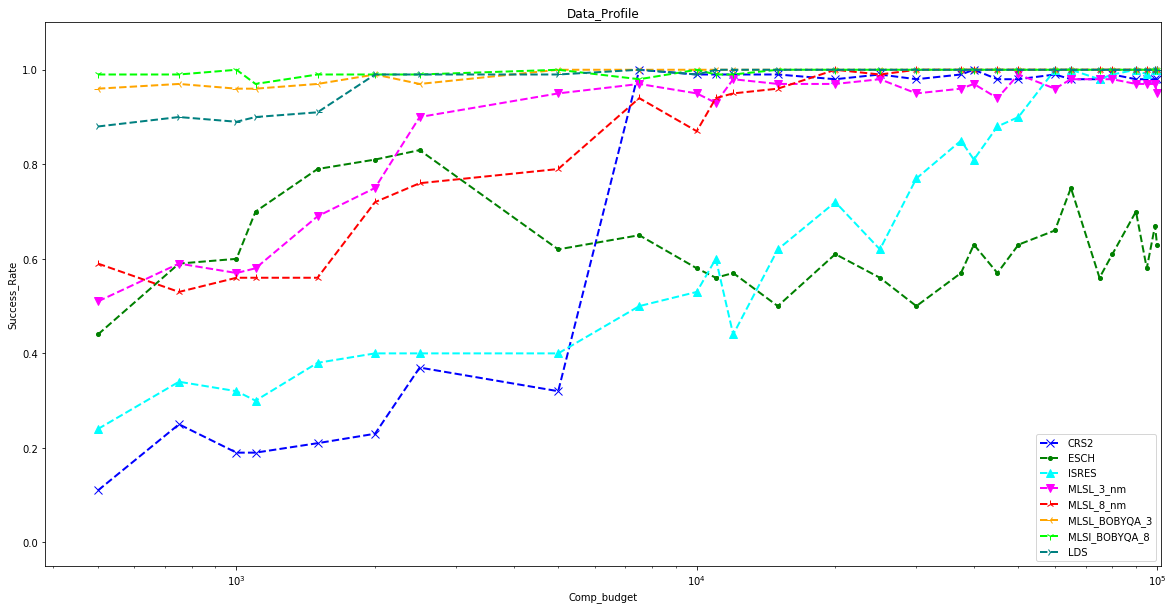

In [7]:
data_profile_general(great_table_grw_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

We can see that for the ten dimensional Griewank function, the algorithms MLSL-LDS,MLSL-BOBYQA-3 and MLSL-BOBYQA-8 achive very high success rates (X-VAL criterion) already at very low computational budgets. For example for a computational budget of 500 objective function evaluations, MLSL-BOBYQA-8 achieves a success rate of 99%. In fact the difference between these three algorithms becomes even smaller as the computational budget (number of max. objective function evaluations allowed) that is available increases. Controlled Random Search (CRS-2) achieves similar success rates at computational budgets of 7500 FEs or higher to achieve success rates in the range between 98%-100%, while ISRES needs 60000 or more objective function evaluations to achieve a similar success rate between 98% and 100%. Similarly MLSL-NM-3 needs 12000 or more objective function evaluations in order to achieve a success rate of 98% or more, and MLSL-NM-8 achieves success rates of 98% or more for computational budgets of 20000 FEs or more. This result implies that for the griewank problem the computationally most efficient algorithms are MLSL-BOBYQA-3,MLSL-BOBYQA-8 and MLSL-LDS because these algorithms achieve very high success rates already for small computational budgets. Another striking fact is that the success rate for the algorithm ESCH first increases and then decreases with increasing budget. I do not have an exact explanation for this behaviour but if I would guess, I would say that with increasing budgets ESCH increases the granularity of the search, by increasing the granularity, worse optimizer are returned, which then in fact impact the local polishing search. The polishing search is affected by the quality of solution the global optimization algorithm returns.  

**Success-Criterion: Deviation in F**

In [8]:
great_table_grw_1=success_results_all(vector_results_list_grw,tau=1e-6,computational_budget=computational_budgets,cols=col_names,success_criterion=1)

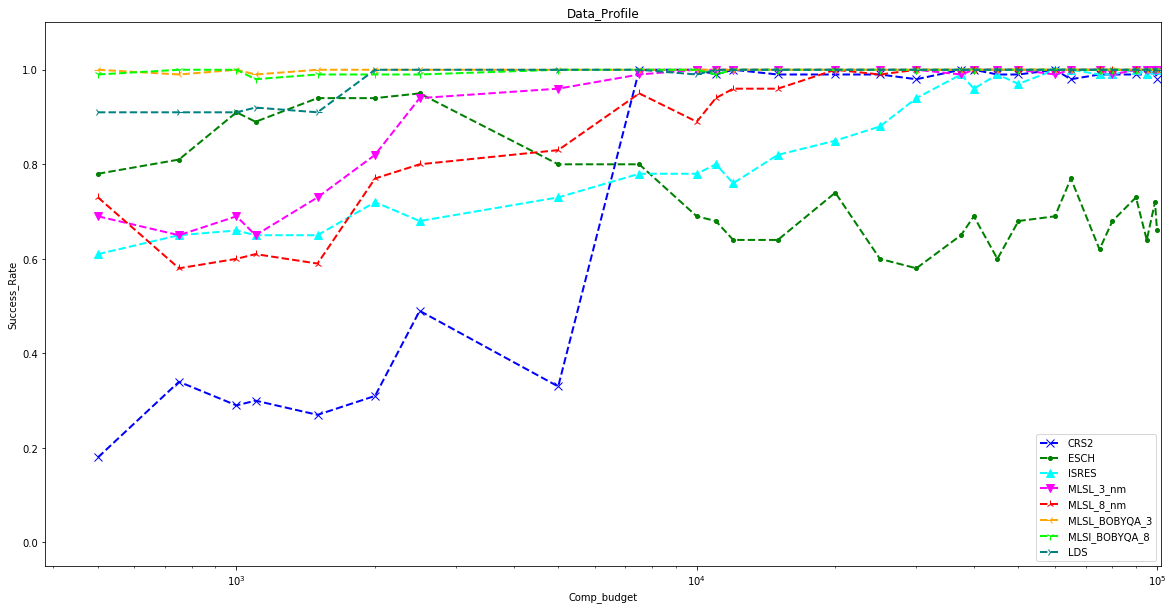

In [9]:
data_profile_general(great_table_grw_1,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

Again for the F-VAL success criterion we can see again that the MLSL-BOBYQA algorithm specifications achieve high success rates already for small computational budgets (number of objective function evaluations). The MLSL-LDS algorithm achieves the same height of success rates for computational budgets of 2000 objective function evaluations or higher. ISRES achieves a comparably high initial success rate of about 60% at a computational budget of 500 allowed objective function evaluations and the success rate gradually increases as the computational budget increases. ISRES achieves success rates of 98% or higher for computational budgets of 37500 allowed objective function evaluations or higher computational budgets. Controlled random search starts with the lowest success rates throughout all lower computational budgets until it achieves success rates around 100% for a computational budget of 7500 objective function evaluations. ESCH has its peak at a budget at a computational budget of 2000 allowed function evaluations with success rates of around 95%. The success rate then drops for computational budgets between 5000 and 100000 and remains within 60-80%. MLSL-NM-3 and MLSL-NM-8 do not have as high initial success rates for very low (500-2500 objective function evaluations allowed) computational budgets as the MLSL-BOBYQA versions. But they achieve a comparable success rate for computational budgets greater than 5000 objective function evaluations.  

---
### 6.1.2 Deviation-Profiles
---

**Success Criterion: Deviation in X**

In [10]:
deviation_res_grw_0=get_deviation_results_all(results_list=vector_results_list_grw,tau=1e-4,success_criterion=0,computational_budget=computational_budgets,info_object=griewank_info_object,cols_algo_names=col_names,n=10,computation_method_x=1)

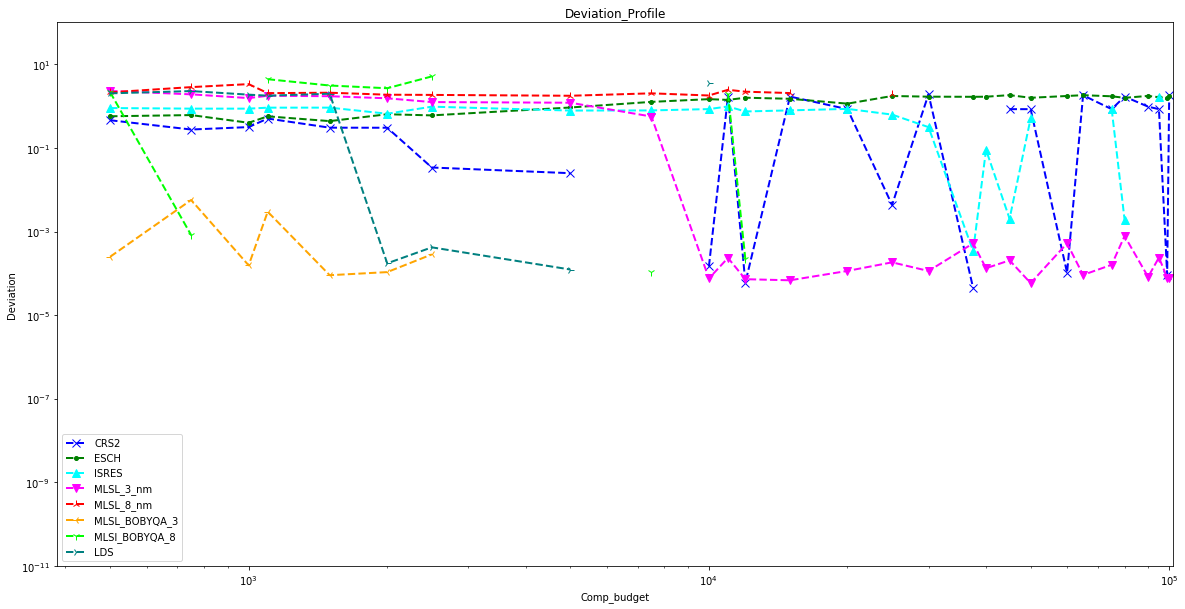

In [11]:
deviation_profile_general(deviation_results_frame=deviation_res_grw_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

The deviation profile plots the deviation of all failed implementations, that have not met the criterion for convergence in X-value. The deviation is computed as mean of root mean squared error across all failed implementations at budget i. This is done for all budgets. We can see that the deviations of the failed implementations of the algorithm ESCH nearly remain constant between $10^1$ and $10^{-1}$ and remains about the same height throughout all computational budgets considered. The deviations of the algorithm ISRES are initially among the highest, and therefore between $10^1$ and $10^{-1}$ but drop substantially to $10^{-3}$, for computational budgets around 10000 FEs and greater computational budgets. This implies that a great extent of these deviations are generally small and would be acceptable for a given economic application. Similarly we can observe a high initial (for lower computational budgets) deviation of failed implementations for MLSL-LDS which then similarly drops to values around $10^{-3}$. For other algorithms we cannot observe a clear trend.

**Success Criterion: Deviation in F**

In [12]:
deviation_res_grw_1=get_deviation_results_all(results_list=vector_results_list_grw,tau=1e-6,success_criterion=1,computational_budget=computational_budgets,info_object=griewank_info_object,cols_algo_names=col_names,n=10,computation_method_x=None)

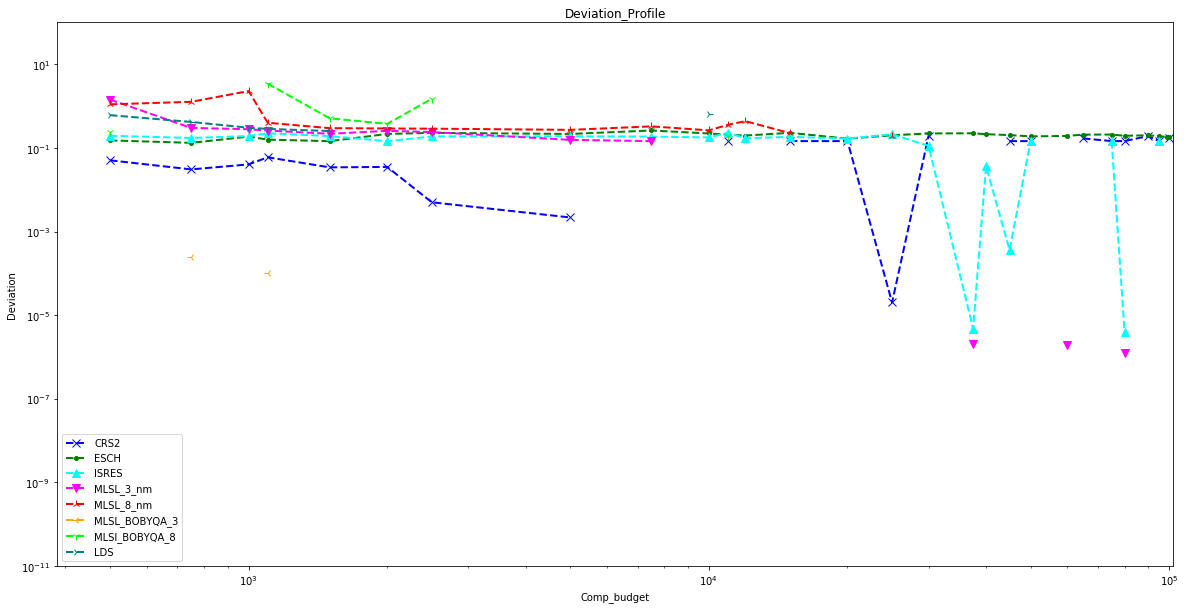

In [13]:
deviation_profile_general(deviation_results_frame=deviation_res_grw_1,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

The deviations for the success criterion, convergence in function value (F-VAL), are initially relatively high across all algorithms, in between $10^1$ and $10^{-1}$ and seem to remain with this trend until high computational budgets, where most of the algorithms achieve success rates around 100%. The deviation profile should be interpreted with caution especially for high computational budgets (high number of allowed objective function evaluations), as for high computational budgets the success rates are high (around 99%) for algorithms like CRS-2, ISRES and the whole eight MLSL algorithms. The deviation profile in these regions therefore often depends on a single or two single failed implementations. So the whole deviation profile in this region depends on a single or two start points where algorithms recursively fail to achieve success. That is one drawback of so called "deviation profiles" as shown in Guvenen et al. (2019).

---
## 6.2 Rastrigin Function
---

In [5]:
############ load results

res_crs2_ras_1='./data/Results/results_rastrigin/results_algo_rast/CRS2_ras.csv'
res_crs2_ras=pd.read_csv(res_crs2_ras_1)
res_isres_ras_1='./data/Results/results_rastrigin/results_algo_rast/ISRES_ras.csv'
res_isres_ras=pd.read_csv(res_isres_ras_1)
res_esch_ras_1='./data/Results/results_rastrigin/results_algo_rast/ESCH_ras.csv'
res_esch_ras=pd.read_csv(res_esch_ras_1)
res_mlsl_nm_3_ras_1='./data/Results/results_rastrigin/results_algo_rast/MLSL_nm_3_ras.csv'
res_mlsl_nm_3_ras=pd.read_csv(res_mlsl_nm_3_ras_1)
res_mlsl_nm_8_ras_1='./data/Results/results_rastrigin/results_algo_rast/MLSL_nm_8_ras.csv'
res_mlsl_nm_8_ras=pd.read_csv(res_mlsl_nm_8_ras_1)
res_mlsl_bob_3_ras_1='./data/Results/results_rastrigin/results_algo_rast/MLSL_bob_3_ras.csv'
res_mlsl_bob_3_ras=pd.read_csv(res_mlsl_bob_3_ras_1)
res_mlsl_bob_8_ras_1='./data/Results/results_rastrigin/results_algo_rast/MLSL_bob_8_ras.csv'
res_mlsl_bob_8_ras=pd.read_csv(res_mlsl_bob_8_ras_1)
res_mlsl_lds_ras_1='./data/Results/results_rastrigin/results_algo_rast/MLSL_LDS_ras.csv'
res_mlsl_lds_ras=pd.read_csv(res_mlsl_lds_ras_1)

In [6]:
vector_results_list_rast=(res_crs2_ras,res_esch_ras,res_isres_ras,res_mlsl_nm_3_ras,res_mlsl_nm_8_ras,res_mlsl_bob_3_ras,
                          res_mlsl_bob_8_ras,res_mlsl_lds_ras)

---
### 6.2.1 Data-Profiles
---

**Success-Criterion: Deviation in X**

In [16]:
great_table_ras_0=success_results_all(vector_results_list_rast,
                                      tau=1e-4,
                                      computational_budget=computational_budgets,
                                      cols=col_names,
                                      success_criterion=0)

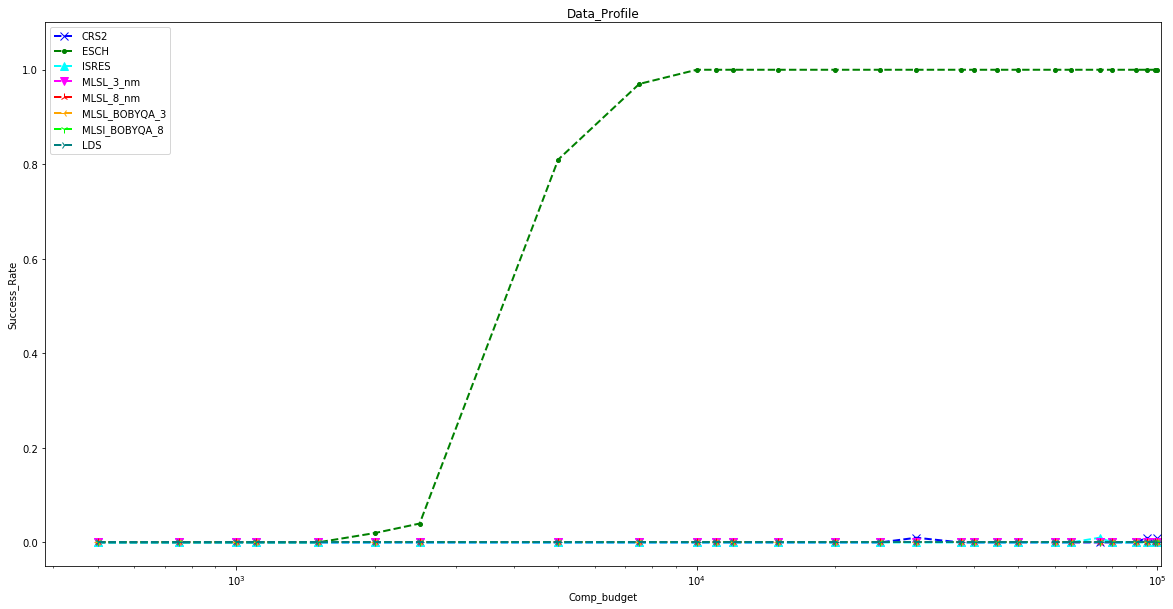

In [17]:
data_profile_general(great_table_ras_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

The data profile shown above depicts the data profile for the rastrigin function. The success criterion is convergence in parameter vector (X-Val). The main impression suggests that the rastrigin function poses a great challenge towards optimization algorithms. All algorithms except ESCH achieve success rates around zero percent for all computational budgets. ESCH is the only algorithm that achieves nonzero success rates. ESCH achieves a success rate (X-Val) of 97% at a computational budget of 7500 FEs. For all greater computational budgets the success rate achieved by ESCH is 100%.

**Success-Criterion: Deviation in F**

In [18]:
great_table_ras_1=success_results_all(vector_results_list_rast,
                                      tau=1e-6,
                                      computational_budget=computational_budgets,
                                      cols=col_names,
                                      success_criterion=1)

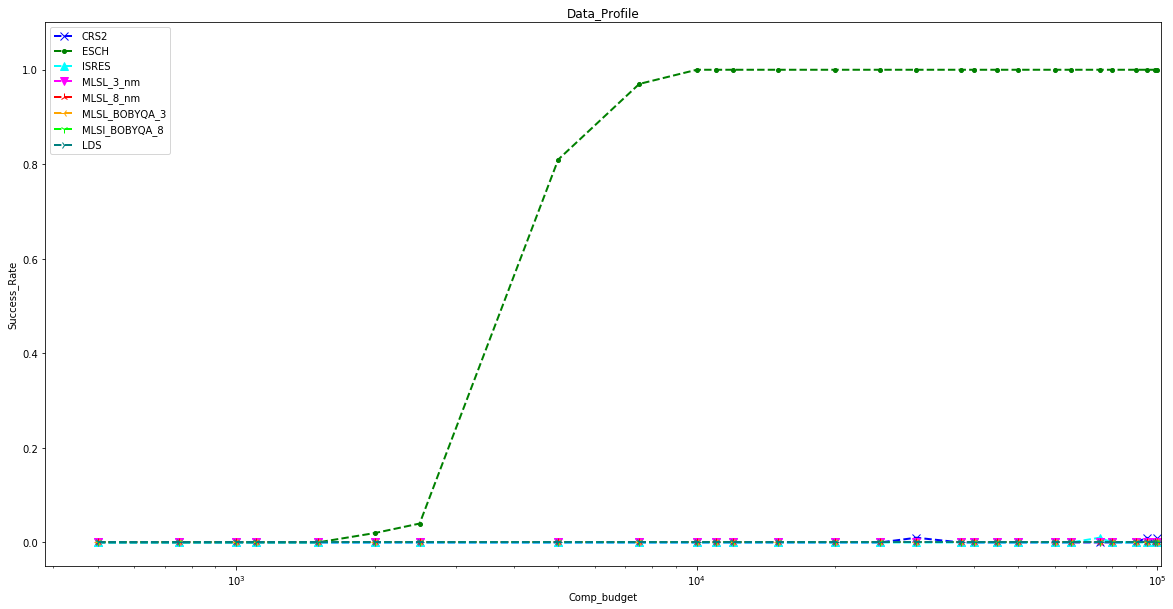

In [19]:
data_profile_general(great_table_ras_1,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

This graph depicts the data profile for the success criterion convergence in function value (F-Val criterion). The data profile shown here is very similar to the data profile shown for the X-Val success criterion. Again all algorithms except for ESCH achieve a success rate that is close to or in most cases even zero for all computational budgets. ESCH again achieves considerably high success rates for computational budgets around 7500 FEs. For all computational budgets above this number, the success rate equals 100%. In order to conclude the section which explain the data profiles, it can be said that the rastrigin function is a challenging function for various kinds of algorithms, that includes multistart algorithms and evolutionary strategy algorithms (because ISRES also failed).

---
### 6.2.2 Deviation-Profiles
---

In [8]:
rastrigin_info_object=rastrigin_info(10,A=10)

**Success Criterion: Deviation in X**

In [18]:
deviation_res_al_rast=get_deviation_results_all(results_list=vector_results_list_rast,
                                           tau=1e-4,
                                           success_criterion=0,
                                           computational_budget=computational_budgets,
                                           info_object=rastrigin_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=1)


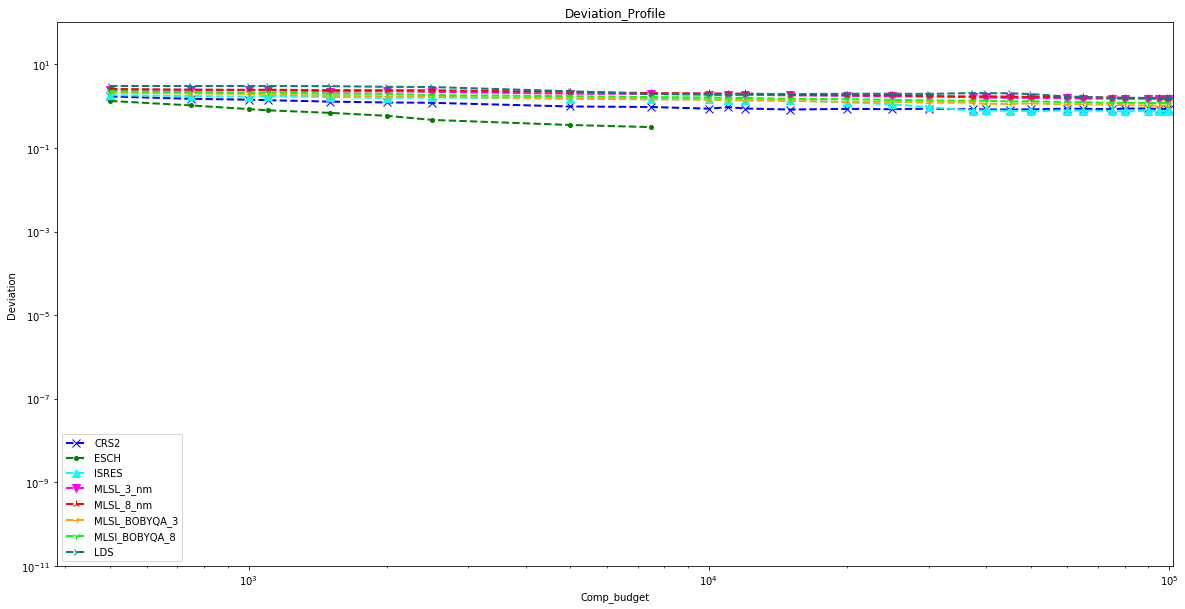

In [19]:
deviation_profile_general(deviation_results_frame=deviation_res_al_rast,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

The deviation profile (rastrigin function) which plot the mean deviation of all failed implementations across all budgets give a clear picture. The mean deviation gets not significantly smaller as we increase the computational budget, and this holds for all algorithms. This implies that adding computational resources do not improve the quality of the result, in the sense that the deviation in the parameter vector vanishes. Combined with the data-profiles shown above these results imply that most of the algorithms are unsuitable to solve this problem and that adding computational capacity does not improve the overall performance of these algorithms (except for ESCH).

**Success Criterion: Deviation in F**

In [20]:
deviation_res_al_rast_1=get_deviation_results_all(results_list=vector_results_list_rast,
                                             tau=1e-6,success_criterion=1,
                                             computational_budget=computational_budgets,
                                             info_object=rastrigin_info_object,cols_algo_names=col_names,
                                             n=10,computation_method_x=None)

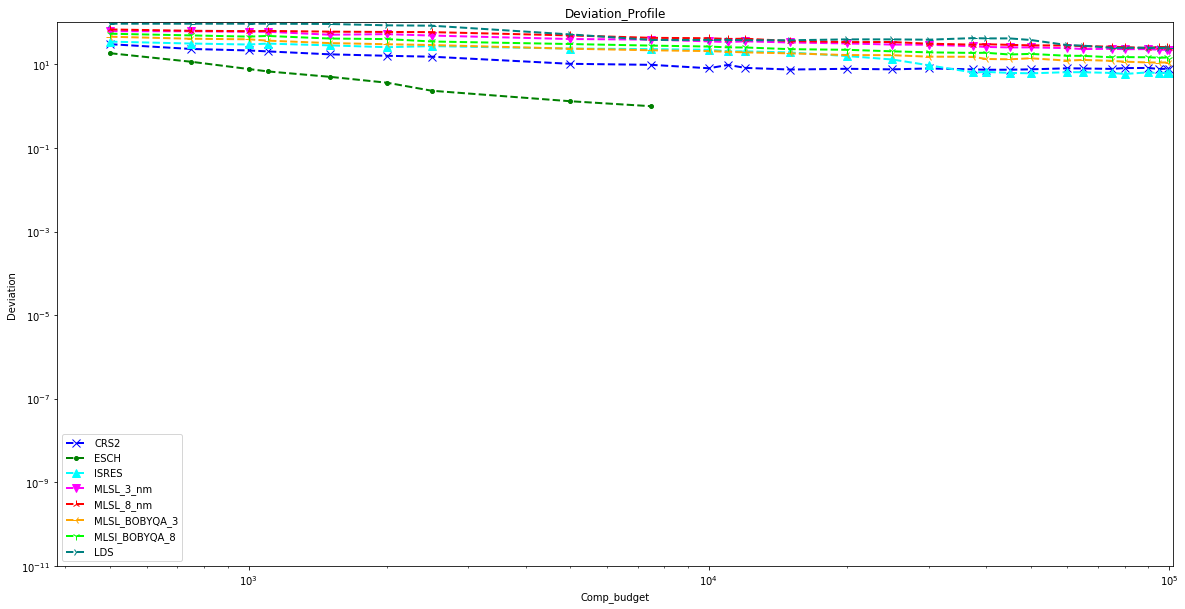

In [21]:
deviation_profile_general(deviation_results_frame=deviation_res_al_rast_1,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

Similarly we can observe the same trend as in the deviation profile above for this deviation profile (Success criterion: F-Val). We can see that the mean deviation of all failed implementations of almost all algorithms is between $10^1$ and $10^2$. This deviation does not significantly decreases with an increasing computational budget. Again this implies that adding computational capacities does not improve the quality of the results obtained. This holds for almost all algorithms except for ESCH, who achieves at least for computational budgets greater than 7500 good success rates (see Data-Profile rastrigin).

---
## 6.3 Levi Function
---

In [7]:
######## load results

res_crs2_lev='./data/Results/results_levi_13/results_algo_levi/CRS2_levi.csv'
res_esch_lev='./data/Results/results_levi_13/results_algo_levi/ESCH_levi.csv'
res_isres_lev='./data/Results/results_levi_13/results_algo_levi/ISRES_levi.csv'
res_mlsl_3_nm_lev='./data/Results/results_levi_13/results_algo_levi/MLSL_nm_3_levi.csv'
res_mlsl_8_nm_lev='./data/Results/results_levi_13/results_algo_levi/MLSL_nm_8_levi.csv'
res_mlsl_3_bob_lev='./data/Results/results_levi_13/results_algo_levi/MLSL_bob_3_levi.csv'
res_mlsl_8_bob_lev='./data/Results/results_levi_13/results_algo_levi/MLSL_bob_8_levi.csv'
res_mlsl_lds_lev='./data/Results/results_levi_13/results_algo_levi/MLSL_LDS_levi.csv'
res_crs2_levi=pd.read_csv(res_crs2_lev)
res_esch_levi=pd.read_csv(res_esch_lev)
res_isres_levi=pd.read_csv(res_isres_lev)
res_mlsl_3_nm_levi=pd.read_csv(res_mlsl_3_nm_lev)
res_mlsl_8_nm_levi=pd.read_csv(res_mlsl_8_nm_lev)
res_mlsl_3_bob_levi=pd.read_csv(res_mlsl_3_bob_lev)
res_mlsl_8_bob_levi=pd.read_csv(res_mlsl_8_bob_lev)
res_mlsl_lds_levi=pd.read_csv(res_mlsl_lds_lev)


In [8]:
vector_results_list_levi=(res_crs2_levi,
                          res_esch_levi,
                          res_isres_levi,
                          res_mlsl_3_nm_levi,
                          res_mlsl_8_nm_levi,res_mlsl_3_bob_levi,res_mlsl_8_bob_levi,res_mlsl_lds_levi)

---
### 6.3.1 Data-Profiles
---

**Success Criterion: Deviation in X**

In [25]:
great_table_levi_0=success_results_all(vector_results_list_levi,tau=1e-4,computational_budget=computational_budgets,cols=col_names,success_criterion=0)

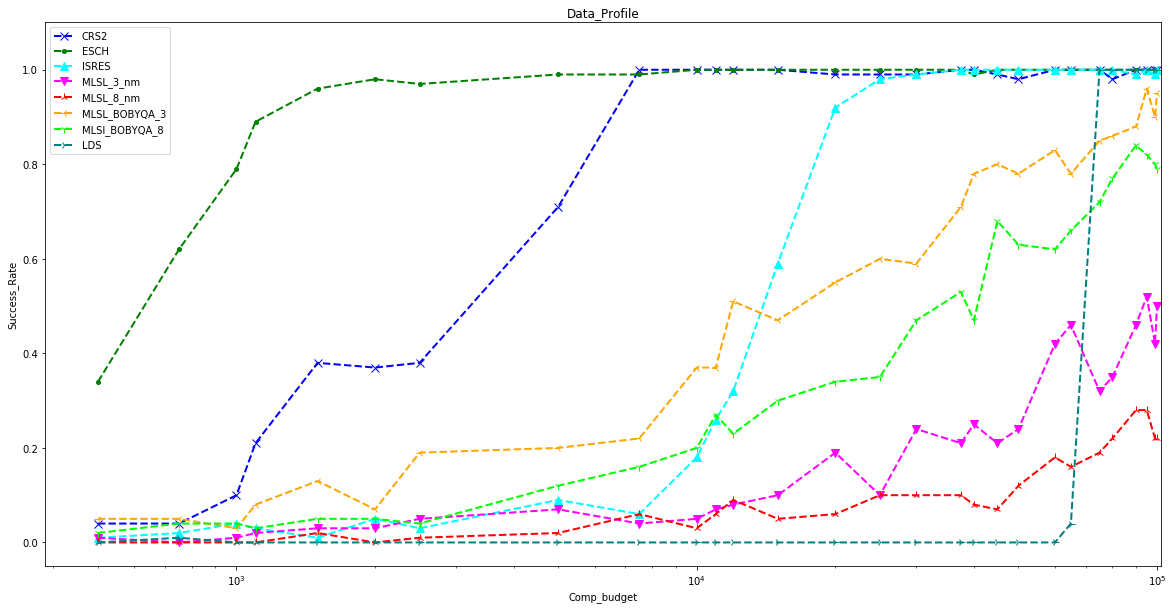

In [26]:
data_profile_general(great_table_levi_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

The data profile (success criterion: X-Val) show an interesting picture. We can see that ESCH is the algorithm that achieves relatively high (around 100%) success rates for a relatively low computational budget of 2500 FEs. No other algorithm can achieve that success level at that computational budget. The second best algorithm is Controlled Random Search two (CRS2-LM) which achieves success rates around 100% for computational budgets higher than 7500 objective function evaluations (FEs). ISRES requires 25000 and more objective function evaluations in order to reach that level of success rates. MLSL-LDS requires 75000 and more objective function evaluations to achieve success rates around 100%. Similarly we can observe for MLSL-BOBYQA-3 and MLSL-BOBYQA-8 that the success rates of these algorithms increase as the budget increases but they stagnate then around 90% and 80% success rate respectively, for high computational budgets above 90000 objective function evaluations. The worst performance of all algorithms is given by the MLSL-NM algorithms, both never achieve higher success rates than approximately 45% even for high computational budgets. So we can see a clear difference between MLSL algorithms which are based on a NELDER MEAD local search algorithm and those MLSL algorithms which entail a local search algorithm which is based on BOBYQA.

**Success Criterion: Deviation in F**

In [31]:
great_table_levi_1=success_results_all(vector_results_list_levi,tau=1e-6,computational_budget=computational_budgets,cols=col_names,success_criterion=1)

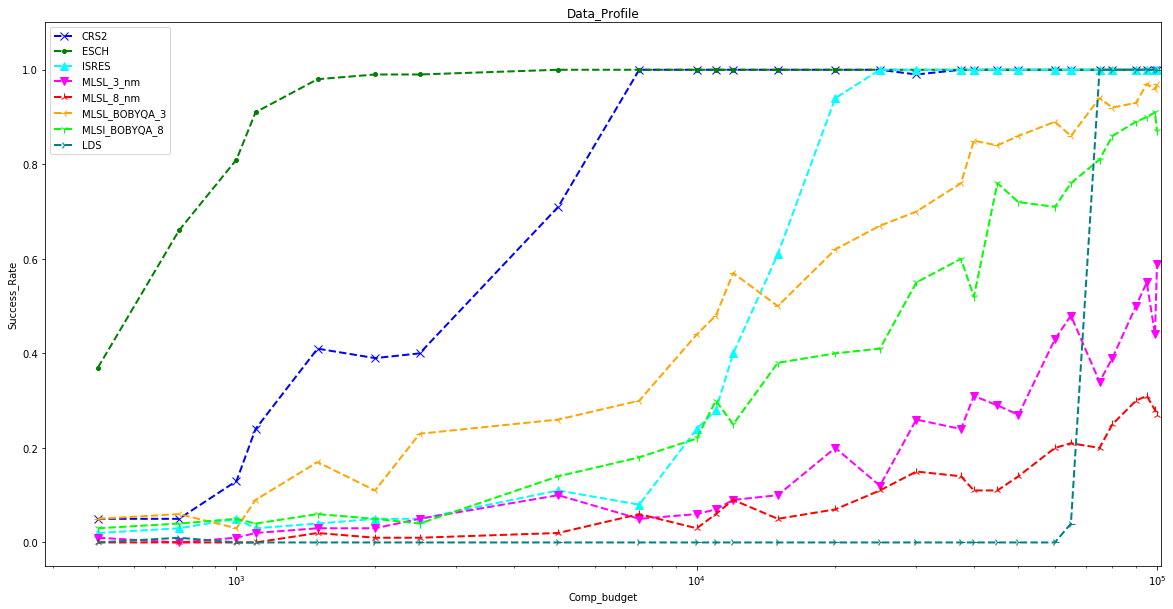

In [32]:
data_profile_general(great_table_levi_1,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

The data profile for the success criterion "deviation in F" looks similar to the data profile shown previously for the other success criterion. Again ESCH is the best optmization algorithm for the Levi function. For a computational budget of 1500 objective function evaluations, ESCH achieves a success rate of 98%. For all higher computational budgets the success rate remains around 100%. This means that ESCH is able to solve the Levi function within the desired tolerance with a high probability already at low computational cost. Again the controlled random search algorithm is the second best algorithm, that achieves success rates around 100% for computational budgets around 10000 objective function evaluations (FEs). The success rate of controlled random search (CRS2) remains at this height for all further computational budgets. ISRES is another algorithm which is considered to be among those algorithms that has been able to reach high success rates within the computational budgets we considered. For computational budgets greater than 25000 objective function evaluations ISRES achieves high success rates around 100%. MLSL-LDS achieves this only for computational budgets around (and above) 75000 objective function evaluations. All other MLSL algorithms do not achieve this height of success rates, but we can observe a clear trend that MLSL algorithms with BOBYQA as local search algorithm outperform those MLSL algorithms with NELDER MEAD as local search algorithm.

---
### 6.3.2 Deviation-Profiles
---

In [11]:
levi_info_object=levi_info(10)

**Success Criterion: Deviation in X**

In [37]:
deviation_res_al_levi_0=get_deviation_results_all(results_list=vector_results_list_levi,
                                           tau=1e-4,
                                           success_criterion=0,
                                           computational_budget=computational_budgets,
                                           info_object=levi_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=0)



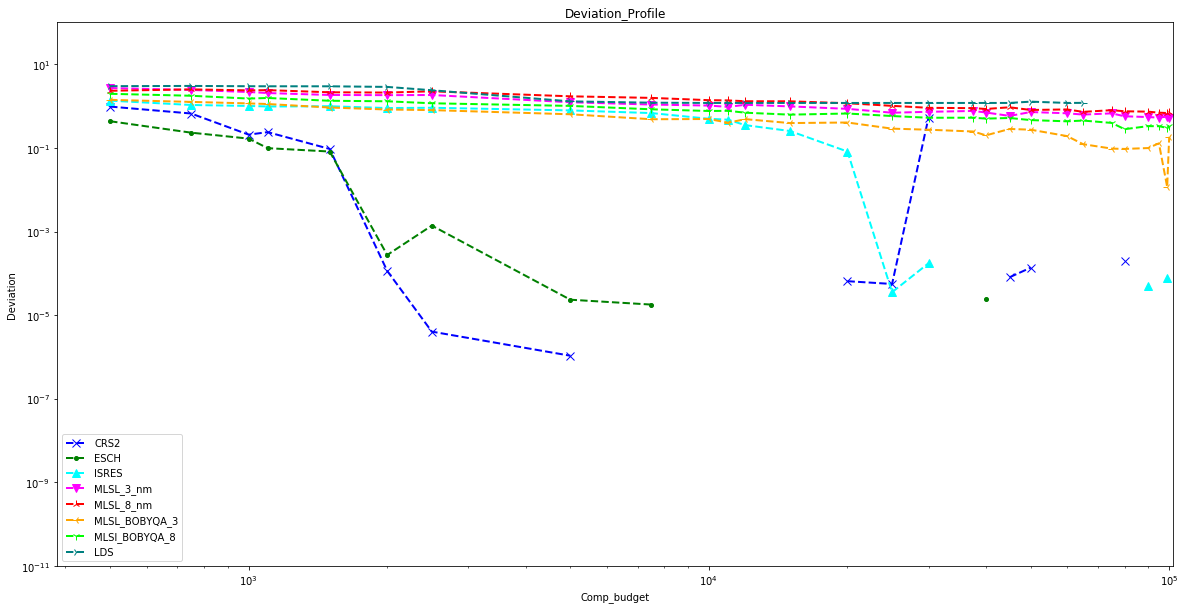

In [38]:
deviation_profile_general(deviation_results_frame=deviation_res_al_levi_0,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

For almost all MLSL algorithms the mean deviation of all failed implementations remains between $10^0$ and $10^1$ implying that the mean deviation of all failed implementations does not vanish as we increase the computational budget. A different deviation profile can be found for the algorithms CRS2, ESCH and ISRES. The mean deviation of failed implementations of the algorithm ESCH decreases as the computational budget increases. For a computational budget of 5000 FEs the mean deviation of failed implementations drops below $10^{-4}$ and stagnates there for higher computational budgets. A similar pattern can be observed for ISRES, the mean deviation among failed implementations of this algorithm remain relatively constant between 1.0 and 2.0 until a computational budget of 12000 FEs. At this budget the drop in the mean deviation among failed implementations begins to decrease. For computational budgets greater than 20000 FEs the mean deviation among failed implementations for ISRES stagnates below $10^{-3}$ and above $10^{-4}$. This implies that although ISRES has some failed implementations for computational budgets above 20000 objective function evaluations, the deviation of these failed implementations is very small, which indicates that ISRES is an algorithm that has the ability to solve the Levi function with high success rates and at comparably low deviations from the true optimum for failed implementations. For CRS2 we cannot observe a clear trend.       

**Success Criterion: Deviation in F**

In [40]:
deviation_res_al_levi_1=get_deviation_results_all(results_list=vector_results_list_levi,
                                           tau=1e-4,
                                           success_criterion=1,
                                           computational_budget=computational_budgets,
                                           info_object=levi_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=None)



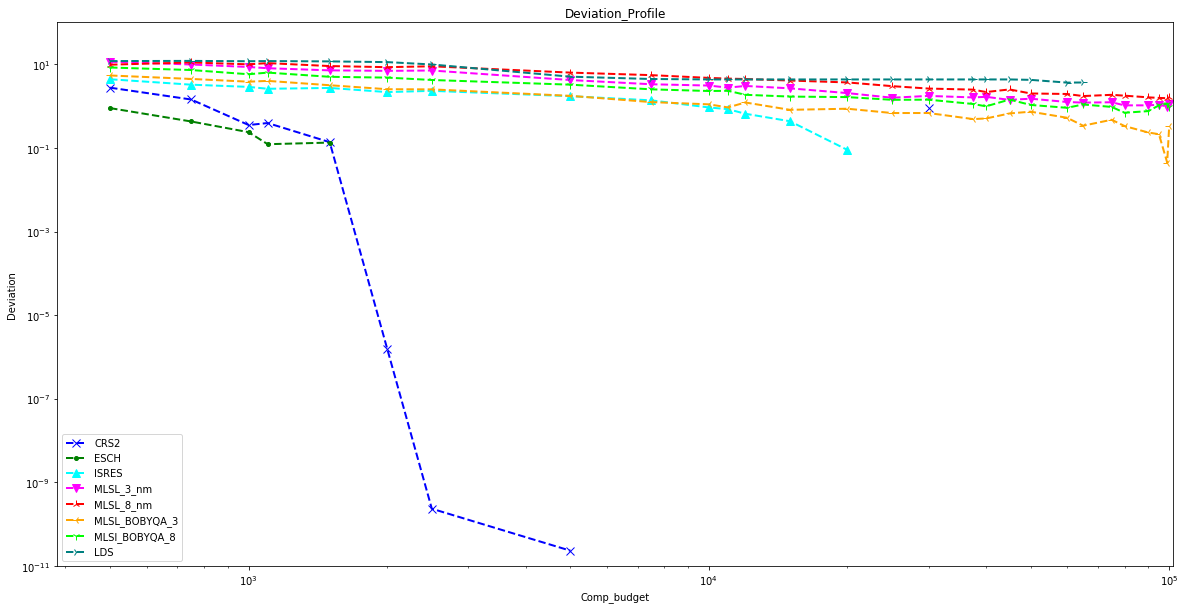

In [41]:
deviation_profile_general(deviation_results_frame=deviation_res_al_levi_1,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

---
## 6.4 Rosenbrock Function
---

In [9]:
######### load csv files

res_crs2_ros='./data/Results/results_rosenbrock/results_algo_rosen/CRS2_rosen.csv'
res_esch_ros='./data/Results/results_rosenbrock/results_algo_rosen/ESCH_rosen.csv'
res_isres_ros='./data/Results/results_rosenbrock/results_algo_rosen/ISRES_rosen.csv'
res_mlsl_3_nm_ros='./data/Results/results_rosenbrock/results_algo_rosen/MLSL_nm_3_rosen.csv'
res_mlsl_8_nm_ros='./data/Results/results_rosenbrock/results_algo_rosen/MLSL_nm_8_rosen.csv'
res_mlsl_3_bob_ros='./data/Results/results_rosenbrock/results_algo_rosen/MLSL_bob_3_rosen.csv'
res_mlsl_8_bob_ros='./data/Results/results_rosenbrock/results_algo_rosen/MLSL_bob_8_rosen.csv'
res_mlsl_lds_ros='./data/Results/results_rosenbrock/results_algo_rosen/MLSL_LDS_rosen.csv'
res_crs2_rosen=pd.read_csv(res_crs2_ros)
res_esch_rosen=pd.read_csv(res_esch_ros)
res_isres_rosen=pd.read_csv(res_isres_ros)
res_mlsl_3_nm_rosen=pd.read_csv(res_mlsl_3_nm_ros)
res_mlsl_8_nm_rosen=pd.read_csv(res_mlsl_8_nm_ros)
res_mlsl_3_bob_rosen=pd.read_csv(res_mlsl_3_bob_ros)
res_mlsl_8_bob_rosen=pd.read_csv(res_mlsl_8_bob_ros)
res_mlsl_lds_rosen=pd.read_csv(res_mlsl_lds_ros)

In [10]:
vector_results_list_rosen=(res_crs2_rosen,res_esch_rosen,
                           res_isres_rosen,res_mlsl_3_nm_rosen,res_mlsl_8_nm_rosen,res_mlsl_3_bob_rosen,
                           res_mlsl_8_bob_rosen,res_mlsl_lds_rosen)

---
### 6.4.1 Data-Profiles
---

**Success Criterion: Deviation in X**

In [44]:
great_table_rosen_0=success_results_all(vector_results_list_rosen,tau=1e-4,computational_budget=computational_budgets,cols=col_names,success_criterion=0)

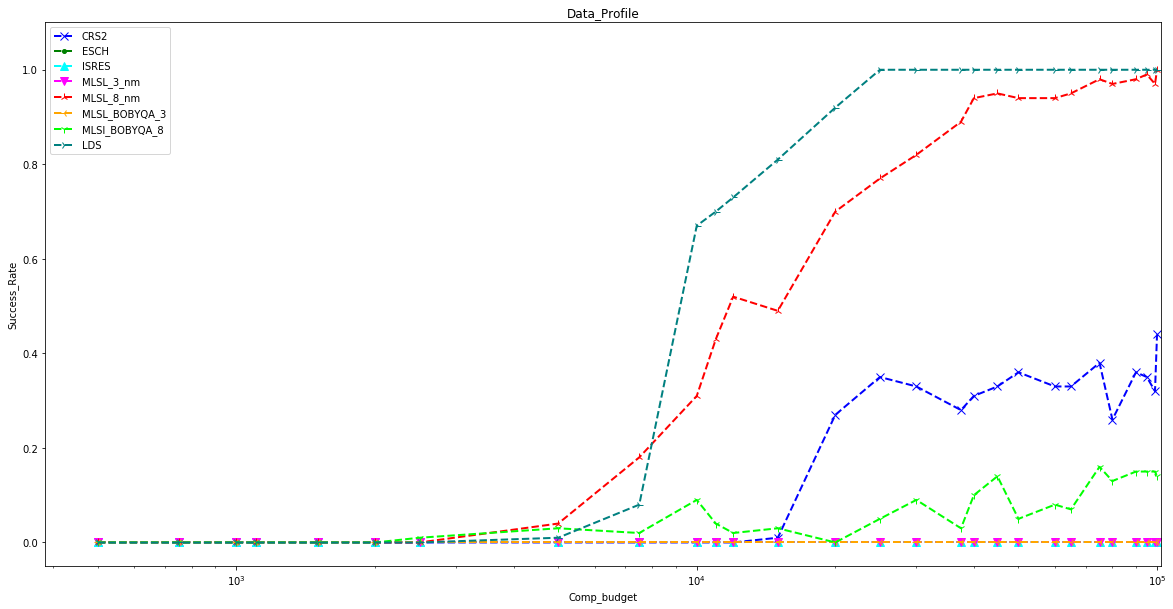

In [46]:
data_profile_general(great_table_rosen_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

**Success Criterion: Deviation in F**

In [47]:
great_table_rosen_1=success_results_all(vector_results_list_rosen,tau=1e-6,computational_budget=computational_budgets,cols=col_names,success_criterion=1)

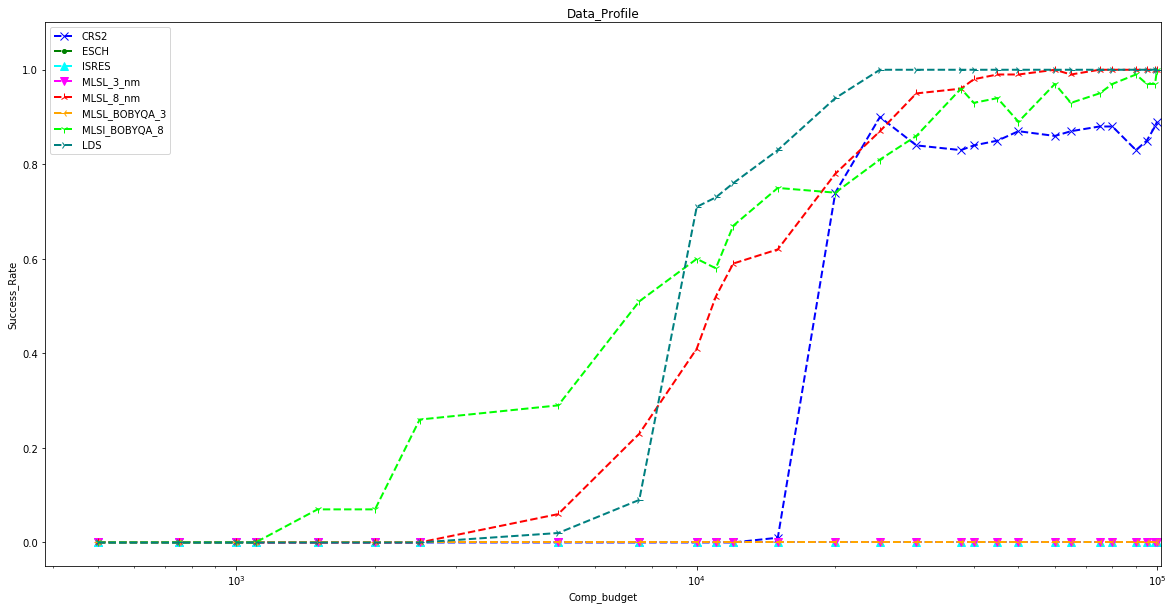

In [48]:
data_profile_general(great_table_rosen_1,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

---
### 6.4.2 Deviation-Profiles
---

In [14]:
rosenbrock_info_object=rosenbrock_info(10)

**Success Criterion: Deviation in X**

In [52]:
deviation_res_al_rosen_0=get_deviation_results_all(results_list=vector_results_list_rosen,
                                           tau=1e-4,
                                           success_criterion=0,
                                           computational_budget=computational_budgets,
                                           info_object=rosenbrock_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=1)



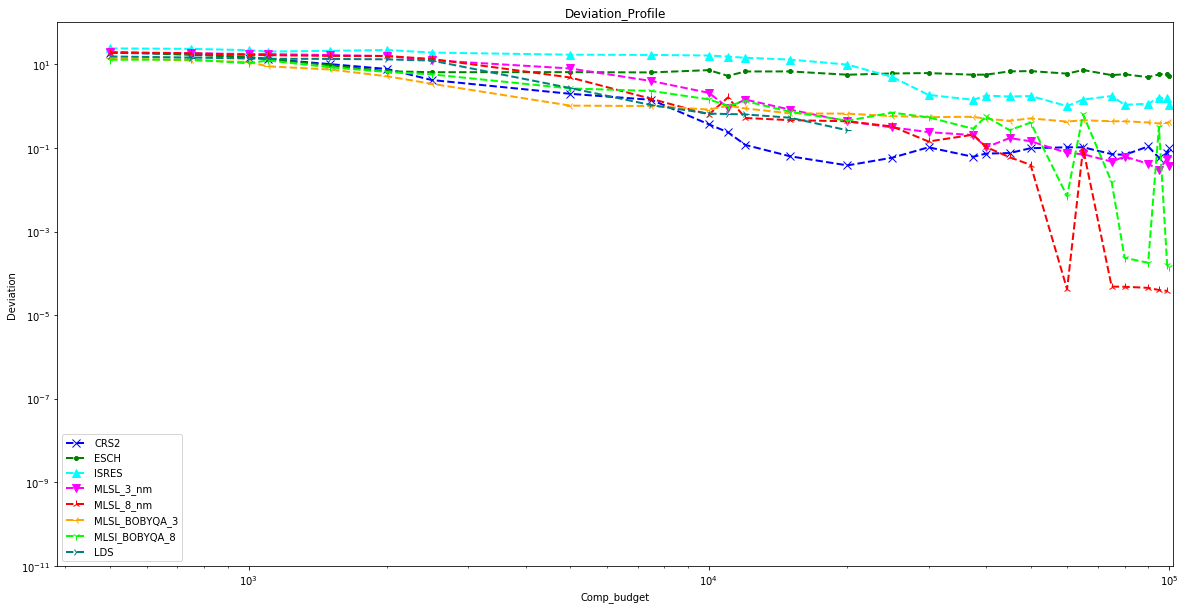

In [53]:
deviation_profile_general(deviation_results_frame=deviation_res_al_rosen_0,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

**Success Criterion: Deviation in F**

In [15]:
deviation_res_al_rosen_1=get_deviation_results_all(results_list=vector_results_list_rosen,
                                           tau=1e-6,
                                           success_criterion=1,
                                           computational_budget=computational_budgets,
                                           info_object=rosenbrock_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=None)


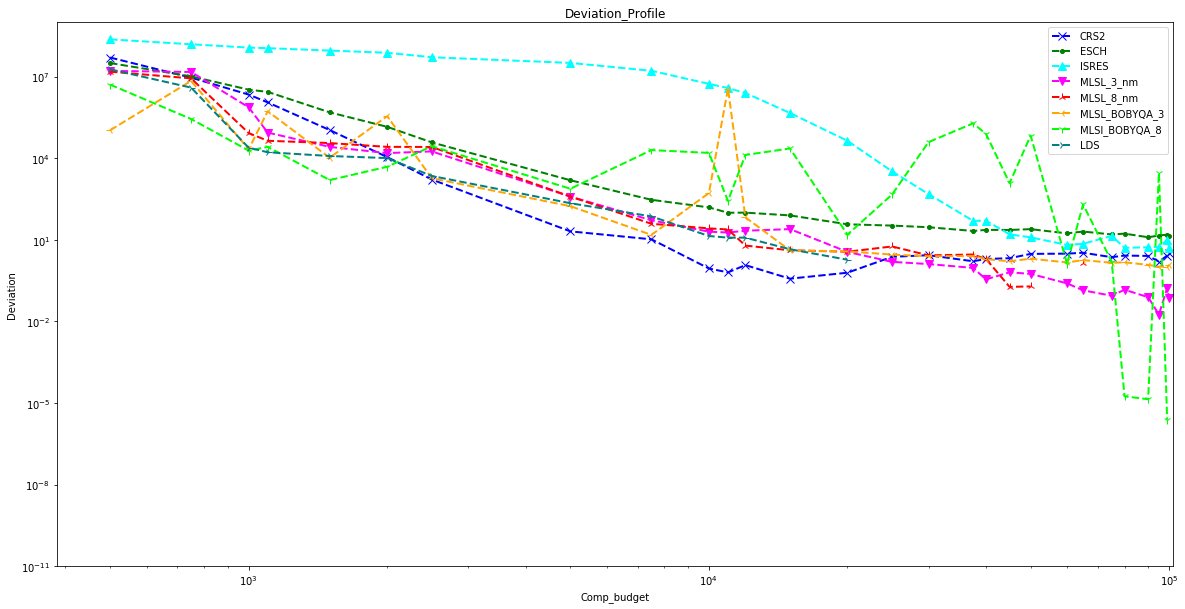

In [16]:
deviation_profile_rosen(deviation_results_frame=deviation_res_al_rosen_1,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

---
## 6.5 Performance Profiles
---

**Success Criterion: Deviation in X**

In [11]:
col_names_perf={0:"CRS2",1:"ESCH",2:"ISRES",3:"MLSL_3_nm",4:"MLSL_8_nm",5:"BOBYQA_3",6:"BOBYQA_8",7:"LDS"}

In [14]:
################ get performance metrics for each function -> Success criterion X

performance_metrics_griewank=get_performance_metrics_revised(results_list=vector_results_list_grw,
                                                             tau=1e-4,success_criterion=0,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)
performance_metrics_rastrigin=get_performance_metrics_revised(results_list=vector_results_list_rast,
                                                             tau=1e-4,success_criterion=0,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)
performance_metrics_levi=get_performance_metrics_revised(results_list=vector_results_list_levi,
                                                             tau=1e-4,success_criterion=0,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)
performance_metrics_rosenbrock=get_performance_metrics_revised(results_list=vector_results_list_rosen,
                                                             tau=1e-4,success_criterion=0,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)

In [15]:
###### define alpha

alpha_performance=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])

In [16]:
metrics_alpha_grw_0=get_performance_metrics_alpha(performance_metrics_griewank,alpha_performance,cols=col_names_perf)
metrics_alpha_rast_0=get_performance_metrics_alpha(performance_metrics_rastrigin,alpha_performance,cols=col_names_perf)
metrics_alpha_levi_0=get_performance_metrics_alpha(performance_metrics_levi,alpha_performance,cols=col_names_perf)
metrics_alpha_rosen_0=get_performance_metrics_alpha(performance_metrics_rosenbrock,alpha_performance,cols=col_names_perf)

In [17]:
metrics_list_0=(metrics_alpha_grw_0,metrics_alpha_rast_0,metrics_alpha_levi_0,metrics_alpha_rosen_0)

In [18]:
metrics_aggregated_0=get_metrics_aggregated(metrics_list_object=metrics_list_0,no_start_points=100,
                                          no_budgets=28,cols=col_names_perf,alpha=alpha_performance)

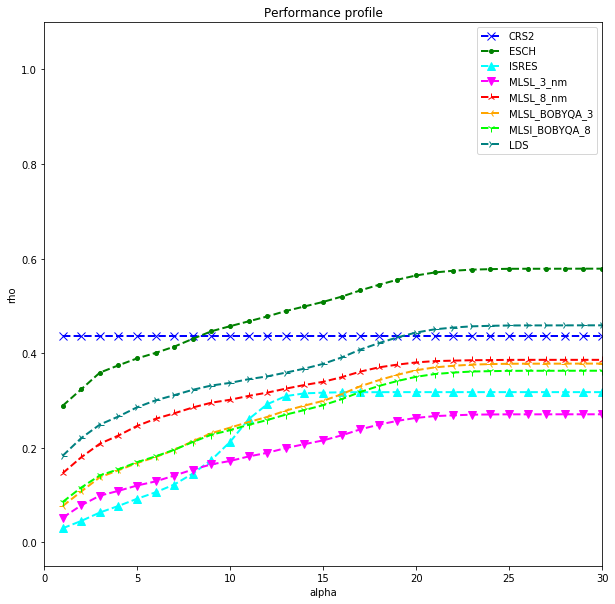

In [19]:
performance_profile(metrics_agg_frame=metrics_aggregated_0,
                    color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

**Success Criterion: Deviation in F**

In [20]:
################ get performance metrics for each function -> Success criterion X

performance_metrics_griewank_1=get_performance_metrics_revised(results_list=vector_results_list_grw,
                                                             tau=1e-6,success_criterion=1,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)
performance_metrics_rastrigin_1=get_performance_metrics_revised(results_list=vector_results_list_rast,
                                                             tau=1e-6,success_criterion=1,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)
performance_metrics_levi_1=get_performance_metrics_revised(results_list=vector_results_list_levi,
                                                             tau=1e-6,success_criterion=1,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)
performance_metrics_rosenbrock_1=get_performance_metrics_revised(results_list=vector_results_list_rosen,
                                                             tau=1e-6,success_criterion=1,
                                                             computational_budget=computational_budgets,
                                                             cols=col_names_perf,n=10)

In [21]:
metrics_alpha_grw_1=get_performance_metrics_alpha(performance_metrics_griewank_1,alpha_performance,cols=col_names_perf)
metrics_alpha_rast_1=get_performance_metrics_alpha(performance_metrics_rastrigin_1,alpha_performance,cols=col_names_perf)
metrics_alpha_levi_1=get_performance_metrics_alpha(performance_metrics_levi_1,alpha_performance,cols=col_names_perf)
metrics_alpha_rosen_1=get_performance_metrics_alpha(performance_metrics_rosenbrock_1,alpha_performance,cols=col_names_perf)

In [22]:
metrics_list_1=(metrics_alpha_grw_1,metrics_alpha_rast_1,metrics_alpha_levi_1,metrics_alpha_rosen_1)

In [23]:
metrics_aggregated_1=get_metrics_aggregated(metrics_list_object=metrics_list_1,no_start_points=100,
                                          no_budgets=28,cols=col_names_perf,alpha=alpha_performance)

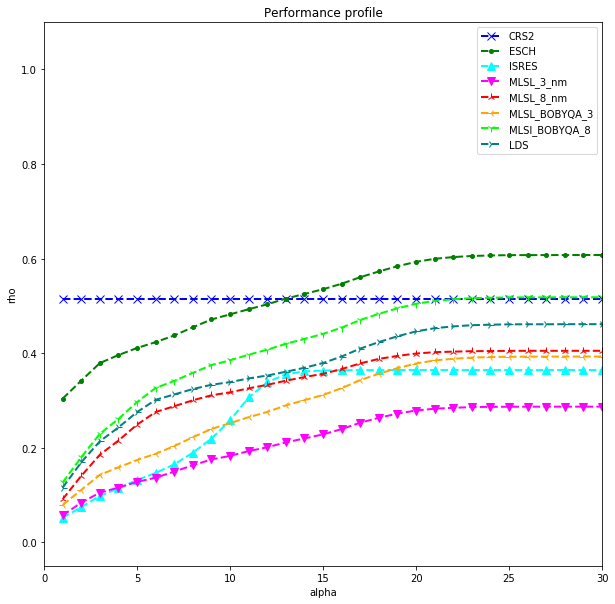

In [24]:
performance_profile(metrics_agg_frame=metrics_aggregated_1,
                    color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

---
# 7. Extension of the Suite of Test Problems
---

We extended the collection of test problems compared to Guvenen et al. (2019). We considered three additional test problems. The additional test problems under consideration are a ten dimensional Ackley function (n=10), a ten dimensional Zakharov function (n=10) and a two dimensional Easom function (n=2). These problems are a diverse collection of test problems, for example the Ackley function is a function with many local minima, the Zakharov function is a function that is plate shaped and the Easom function has steep ridges/ drops (see Surjanovic & Bingham, 2013). The details about this functions are illustrated in Surjanovic and Bingham (2013).

---
# 7.1 Ackley Function
---

In [3]:
###### load csv files

res_crs2_ack='./data/Results/results_ackley/results_algo_ackley/CRS2_ackley.csv'
res_esch_ack='./data/Results/results_ackley/results_algo_ackley/ESCH_ackley.csv'
res_isres_ack='./data/Results/results_ackley/results_algo_ackley/ISRES_ackley.csv'
res_mlsl_3_nm_ack='./data/Results/results_ackley/results_algo_ackley/MLSL_nm_3_ackley.csv'
res_mlsl_8_nm_ack='./data/Results/results_ackley/results_algo_ackley/MLSL_nm_8_ackley.csv'
res_mlsl_3_bob_ack='./data/Results/results_ackley/results_algo_ackley/MLSL_bob_3_ackley.csv'
res_mlsl_8_bob_ack='./data/Results/results_ackley/results_algo_ackley/MLSL_bob_8_ackley.csv'
res_mlsl_lds_ack='./data/Results/results_ackley/results_algo_ackley/MLSL_LDS_ackley.csv'
res_crs2_ackley=pd.read_csv(res_crs2_ack)
res_esch_ackley=pd.read_csv(res_esch_ack)
res_isres_ackley=pd.read_csv(res_isres_ack)
res_mlsl_3_nm_ackley=pd.read_csv(res_mlsl_3_nm_ack)
res_mlsl_8_nm_ackley=pd.read_csv(res_mlsl_8_nm_ack)
res_mlsl_3_bob_ackley=pd.read_csv(res_mlsl_3_bob_ack)
res_mlsl_8_bob_ackley=pd.read_csv(res_mlsl_8_bob_ack)
res_mlsl_lds_ackley=pd.read_csv(res_mlsl_lds_ack)

In [4]:
vector_results_list_ackley=(res_crs2_ackley,res_esch_ackley,
                            res_isres_ackley,res_mlsl_3_nm_ackley,res_mlsl_8_nm_ackley,res_mlsl_3_bob_ackley,
                            res_mlsl_8_bob_ackley,res_mlsl_lds_ackley)

---
## 7.1.1 Data Profiles
---

**Success Criterion: Deviation in X**

In [7]:
great_table_ackley_0=success_results_all(vector_results_list_ackley,tau=1e-4,computational_budget=computational_budgets,cols=col_names,success_criterion=0)

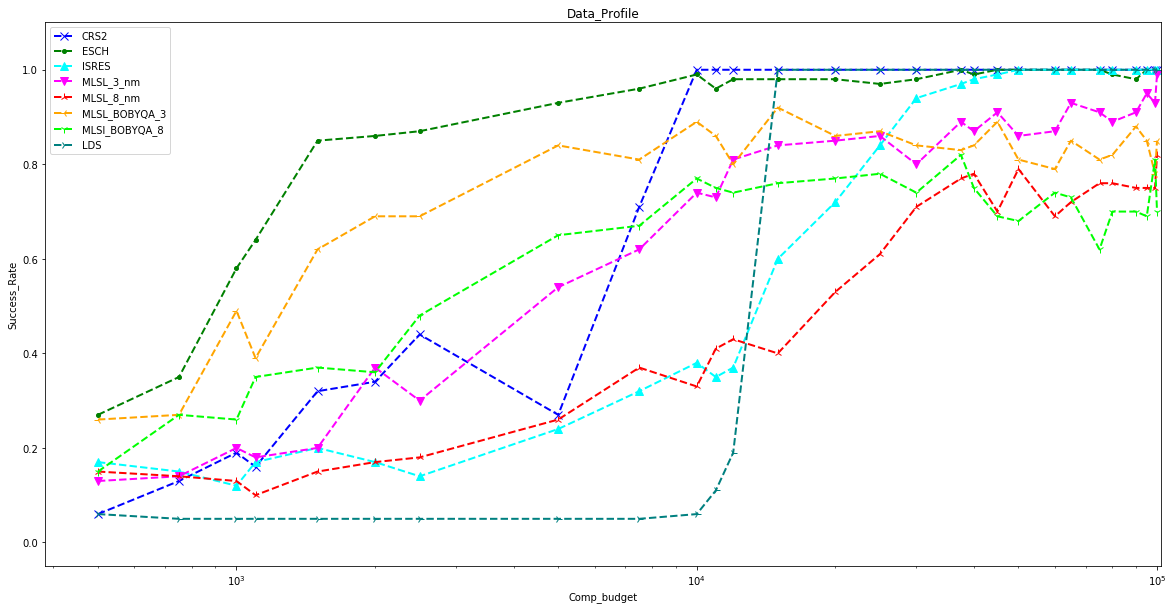

In [8]:
data_profile_general(great_table_ackley_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

**Success Criterion: Deviation in F**

In [9]:
great_table_ackley_1=success_results_all(vector_results_list_ackley,tau=1e-6,computational_budget=computational_budgets,cols=col_names,success_criterion=1)

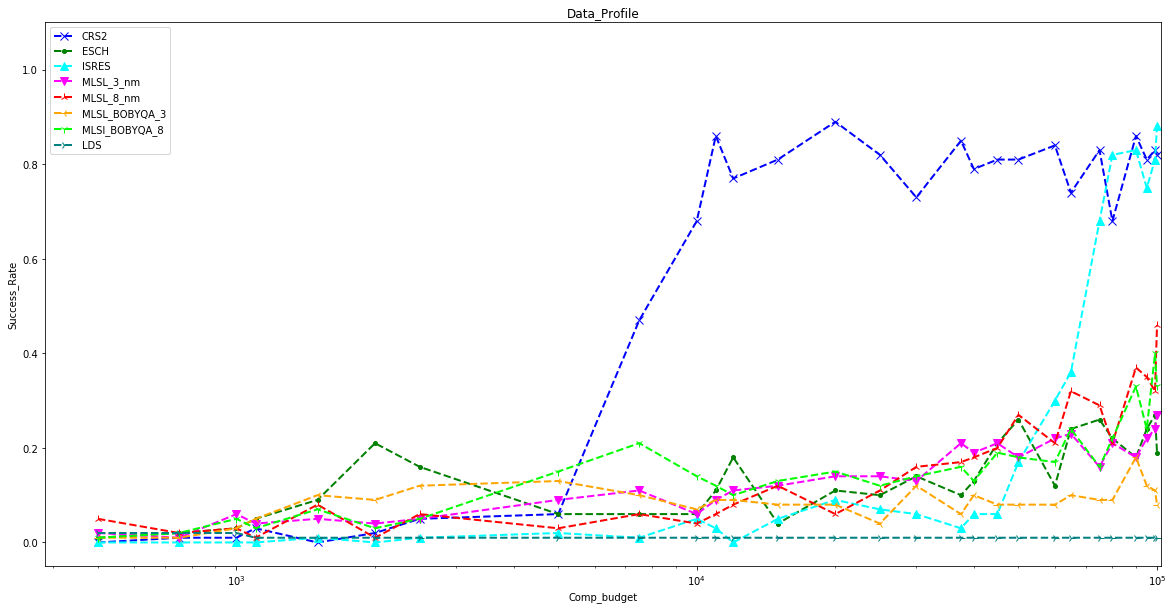

In [10]:
data_profile_general(great_table_ackley_1,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

---
## 7.1.1 Deviation Profiles
---

In [11]:
ackley_info_object=ackley_info(10)

**Success Criterion: Deviation in X**

In [12]:
deviation_res_al_ackley_0=get_deviation_results_all(results_list=vector_results_list_ackley,
                                           tau=1e-4,
                                           success_criterion=0,
                                           computational_budget=computational_budgets,
                                           info_object=ackley_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=1)

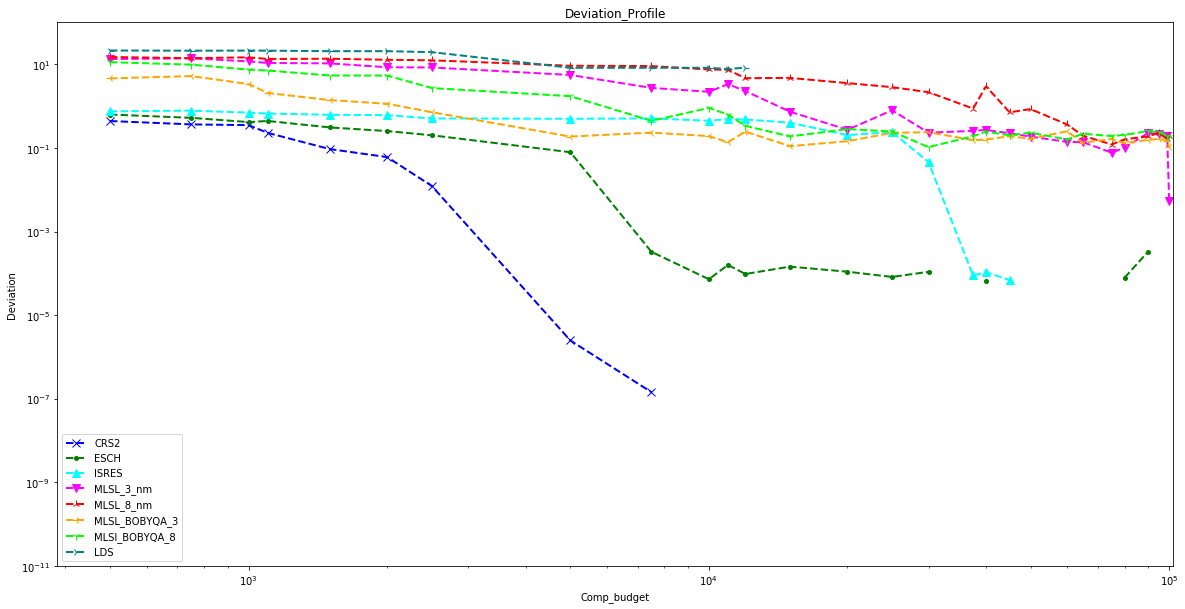

In [13]:
deviation_profile_general(deviation_results_frame=deviation_res_al_ackley_0,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

**Success Criterion: Deviation in F**

In [14]:
deviation_res_al_ackley_1=get_deviation_results_all(results_list=vector_results_list_ackley,
                                           tau=1e-6,
                                           success_criterion=1,
                                           computational_budget=computational_budgets,
                                           info_object=ackley_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=None)

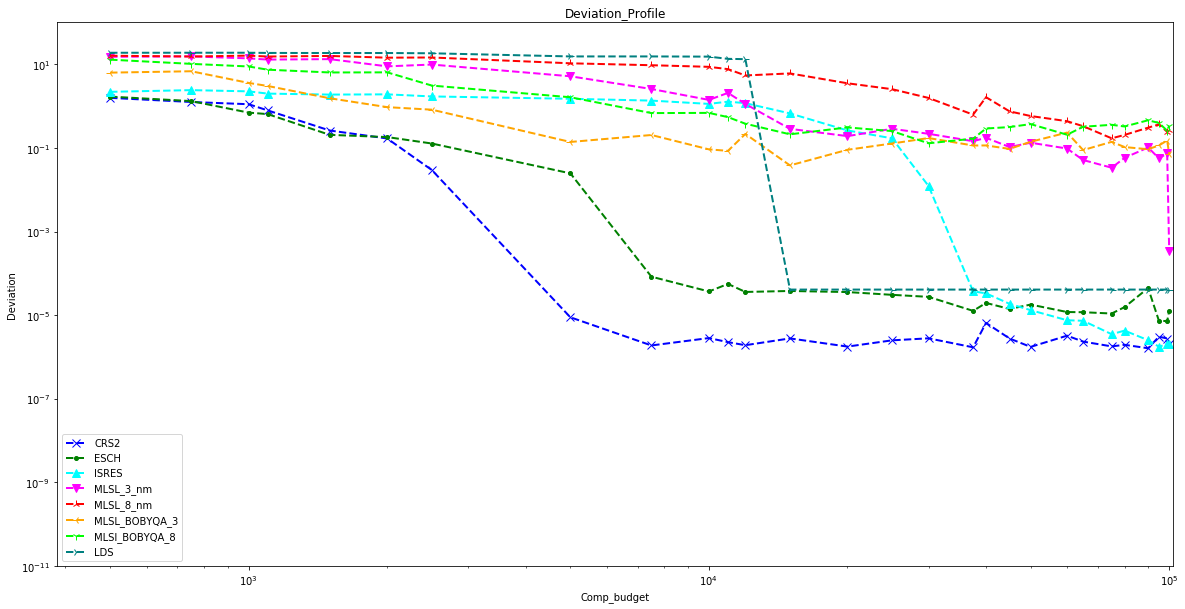

In [15]:
deviation_profile_general(deviation_results_frame=deviation_res_al_ackley_1,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

---
# 7.2 Zakharov Function
---

In [16]:
res_crs2_zak='./data/Results/results_zakharov/results_algo_zak/CRS2_zak.csv'
res_esch_zak='./data/Results/results_zakharov/results_algo_zak/ESCH_zak.csv'
res_isres_zak='./data/Results/results_zakharov/results_algo_zak/ISRES_zak.csv'
res_mlsl_3_nm_zak='./data/Results/results_zakharov/results_algo_zak/MLSL_nm_3_zak.csv'
res_mlsl_8_nm_zak='./data/Results/results_zakharov/results_algo_zak/MLSL_nm_8_zak.csv'
res_mlsl_3_bob_zak='./data/Results/results_zakharov/results_algo_zak/MLSL_bob_3_zak.csv'
res_mlsl_8_bob_zak='./data/Results/results_zakharov/results_algo_zak/MLSL_bob_8_zak.csv'
res_mlsl_lds_zak='./data/Results/results_zakharov/results_algo_zak/MLSL_LDS_zak.csv'
res_crs2_zakh=pd.read_csv(res_crs2_zak)
res_esch_zakh=pd.read_csv(res_esch_zak)
res_isres_zakh=pd.read_csv(res_isres_zak)
res_mlsl_3_nm_zakh=pd.read_csv(res_mlsl_3_nm_zak)
res_mlsl_8_nm_zakh=pd.read_csv(res_mlsl_8_nm_zak)
res_mlsl_3_bob_zakh=pd.read_csv(res_mlsl_3_bob_zak)
res_mlsl_8_bob_zakh=pd.read_csv(res_mlsl_8_bob_zak)
res_mlsl_lds_zakh=pd.read_csv(res_mlsl_lds_zak)

In [17]:
vector_results_list_zak=(res_crs2_zakh,res_esch_zakh,
                         res_isres_zakh,res_mlsl_3_nm_zakh,res_mlsl_8_nm_zakh,res_mlsl_3_bob_zakh,
                         res_mlsl_8_bob_zakh,res_mlsl_lds_zakh)

---
# 7.2.2 Data-Profiles
---

**Success-Criterion: Deviation in X**

In [18]:
great_table_zakharov_0=success_results_all(vector_results_list_zak,tau=1e-4,computational_budget=computational_budgets,cols=col_names,success_criterion=0)

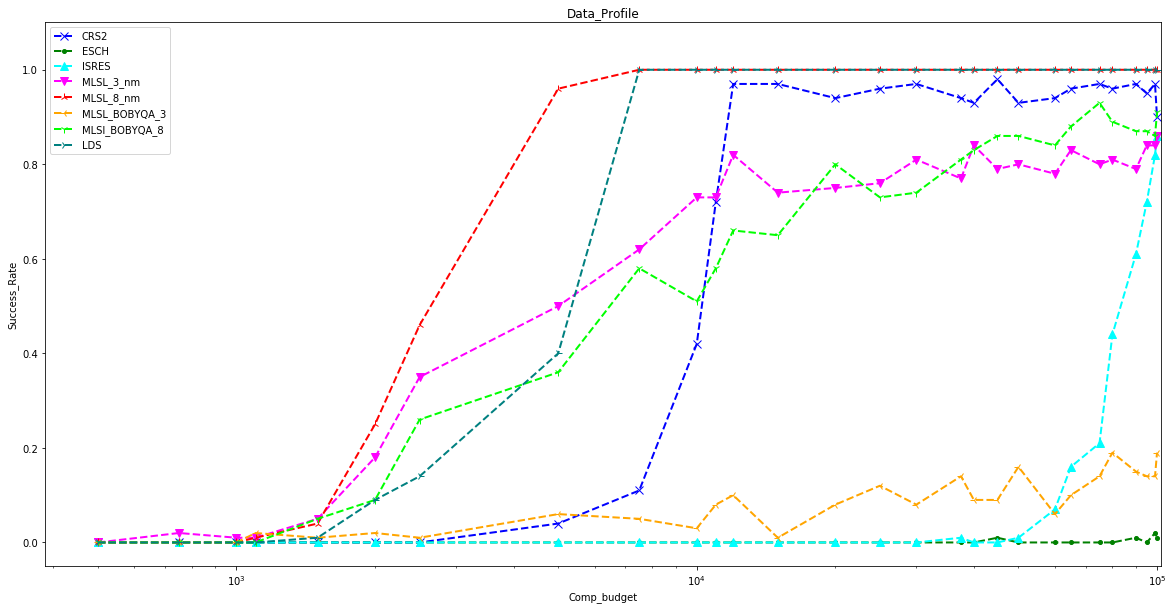

In [19]:
data_profile_general(great_table_zakharov_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

**Success Criterion: Deviation in F**

In [20]:
great_table_zakharov_1=success_results_all(vector_results_list_zak,tau=1e-6,computational_budget=computational_budgets,cols=col_names,success_criterion=1)

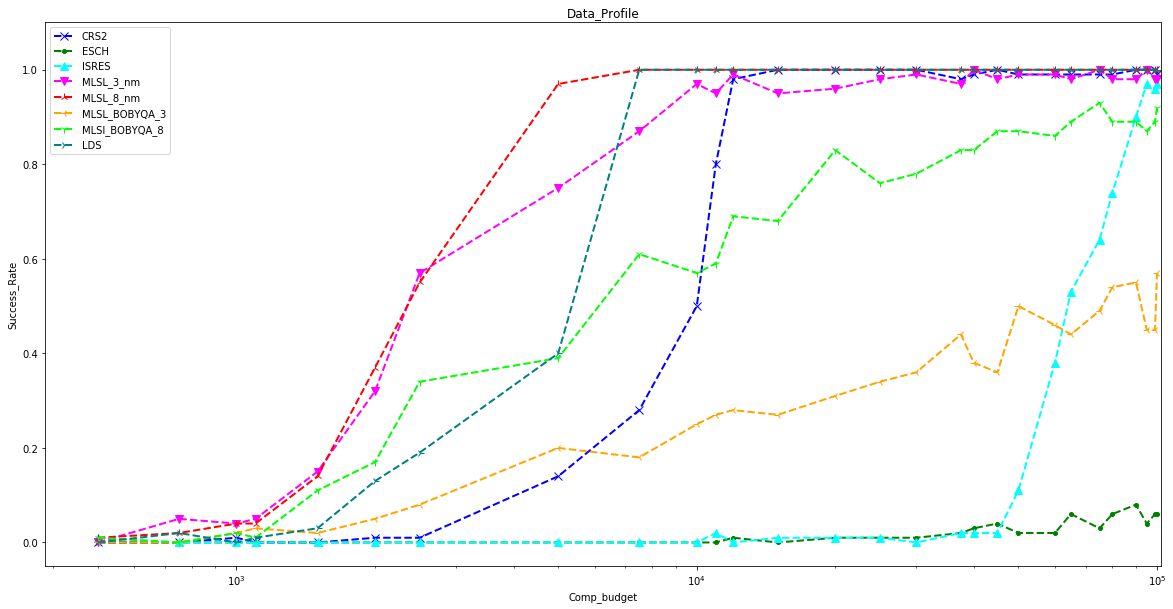

In [21]:
data_profile_general(great_table_zakharov_1,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_2)

---
# 7.2.3 Deviation-Profiles
---

In [22]:
zakharov_info_object=zakharov_info(10)

**Success Criterion: Deviation in X**

In [23]:
deviation_res_al_zakharov_0=get_deviation_results_all(results_list=vector_results_list_zak,
                                           tau=1e-4,
                                           success_criterion=0,
                                           computational_budget=computational_budgets,
                                           info_object=zakharov_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=1)

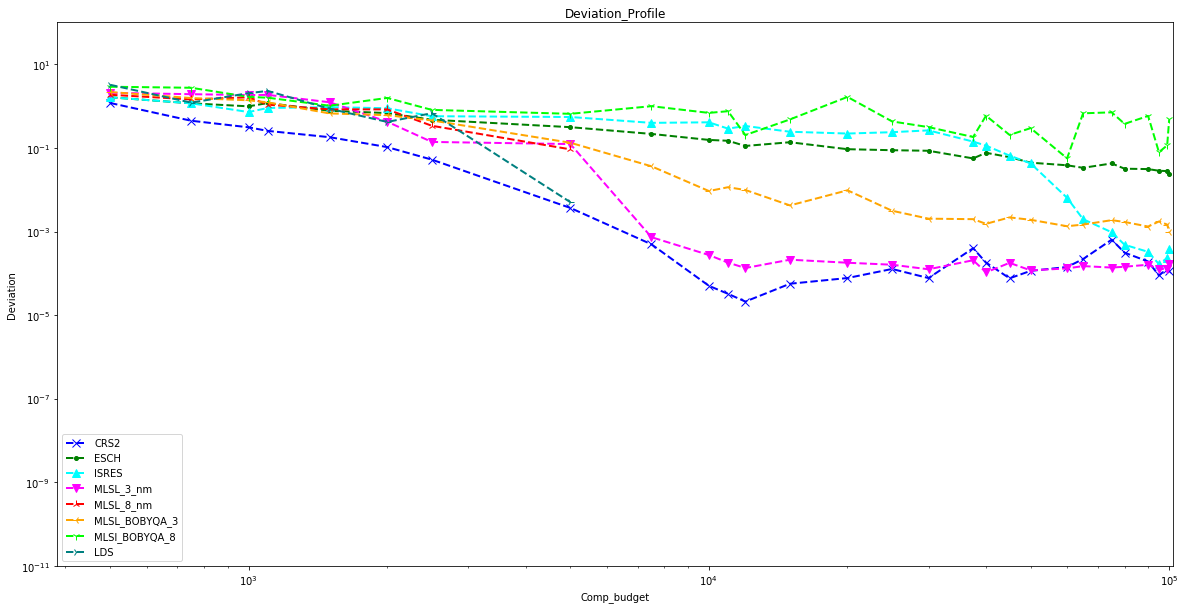

In [24]:
deviation_profile_general(deviation_results_frame=deviation_res_al_zakharov_0,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

**Success Criterion: Deviation in F**

In [25]:
deviation_res_al_zakharov_1=get_deviation_results_all(results_list=vector_results_list_zak,
                                           tau=1e-6,
                                           success_criterion=1,
                                           computational_budget=computational_budgets,
                                           info_object=zakharov_info_object,
                                           cols_algo_names=col_names,
                                           n=10,
                                           computation_method_x=None)

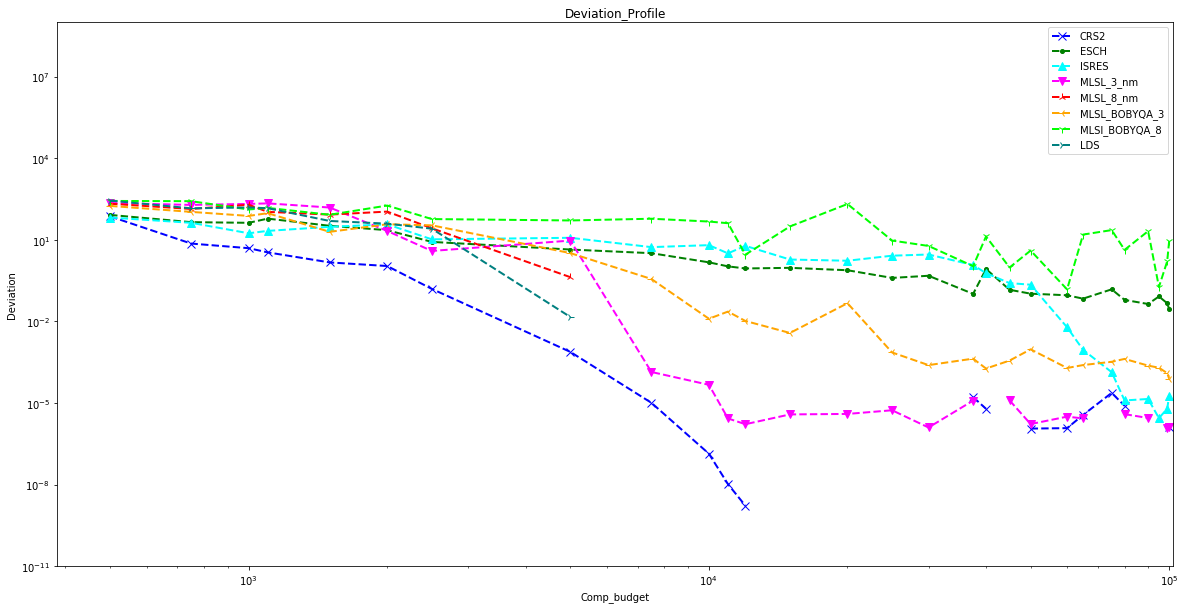

In [27]:
deviation_profile_rosen(deviation_results_frame=deviation_res_al_zakharov_1,
                          color_vector=color_vector_1,
                          marker_vector=marker_vector_1,
                          algo_names=algo_names_2)

---
# 7.2 Easom Function
---

In [28]:
res_crs2_eas='./data/Results/results_easom/results_algo_easom/CRS2_easom.csv'
res_esch_eas='./data/Results/results_easom/results_algo_easom/ESCH_easom.csv'
res_isres_eas='./data/Results/results_easom/results_algo_easom/ISRES_easom.csv'
res_mlsl_3_nm_eas='./data/Results/results_easom/results_algo_easom/MLSL_nm_3_easom.csv'
res_mlsl_8_nm_eas='./data/Results/results_easom/results_algo_easom/MLSL_nm_8_easom.csv'
res_crs2_easom=pd.read_csv(res_crs2_eas)
res_esch_easom=pd.read_csv(res_esch_eas)
res_isres_easom=pd.read_csv(res_isres_eas)
res_mlsl_3_nm_easom=pd.read_csv(res_mlsl_3_nm_eas)
res_mlsl_8_nm_easom=pd.read_csv(res_mlsl_8_nm_eas)

---
# 8. Extension: Economic Application
---

In order to showcast that optimization algorithms can be beneficial for economic applications we constructed a **Mean Variance Optimization** problem based on Markowitz (1952).<br>
The general model and minimization problem is defined by the following formula (a very basic version of Markowitz):<br><br>
\begin{align}
\min_x u(x)=\alpha^T_{1\times n}x_{n\times1}+\lambda_{1\times1} x^T_{1\times n}*Q_{n\times n}*x_{n\times 1}\\
s.t.\sum_{i=1}^n x_i=B\\
s.t. x_i\geq0\\
s.t. x_i\leq B
\end{align}<br><br>
where $n$ is the universe of assets that we are able to purchase, $x_i$ is the amount of asset $i$ we hold in the portfolio. The variable B is the budget we consider. The vector $\alpha$ contains the expected returns of the corresponding assets, $Q$ is a variance-covariance matrix of expected returns and $\lambda$ is a risk aversion parameter. The goal is to maximize the utility by minimizing the objective function. We want to minimize the second term and to maximize the first term, because the agent wants the lowest risk for a given portfolio return. We will consider a minimization problem of dimension $n=3$.<br>
For the three dimensional case the objective function shown above in matrix notation is given by:<br><br>
\begin{align}
\min_x u(x)= -
\begin{pmatrix}
\alpha_1& \alpha_2 &\alpha_3\\
\end{pmatrix}
\begin{pmatrix}
x_1\\ x_2 \\ x_3\\
\end{pmatrix}+
\lambda \cdot
\begin{pmatrix}
x_1& x_2 &x_3\\
\end{pmatrix}*
\begin{pmatrix}
\sigma_{x_1}^2 & \sigma_{x_1,x_2} & \sigma_{x_1,x_3}\\
\sigma_{x_1,x_2} & \sigma_{x_2}^2 & \sigma_{x_2,x_3}\\
\sigma_{x_1,x_3} & \sigma_{x_2,x_3} & \sigma_{x_3}^2
\end{pmatrix}*
\begin{pmatrix}
x_1\\ x_2 \\ x_3\\
\end{pmatrix}
\end{align}<br>
subject to the constraints:
\begin{align*}
x_1+x_2+x_3=B\\
0\leq x_1\leq B\\
0\leq x_2\leq B\\
0\leq x_3\leq B
\end{align*}
We can do matrix algebra in order to specify the objective function:<br><br>
\begin{align*}
\min_x u(x)=&-\alpha_1x_1-\alpha_2x_2-\alpha_3x_3+\lambda(\sigma_{x_1}^2x_1^2+\sigma_{x_2}^2x_2^2+\sigma_{x_3}^2x_3^2 \\
&+2\sigma_{x_1,x_2}x_1x_2+2\sigma_{x_1,x_3}x_1x_3+2\sigma_{x_2,x_3}x_2x_3)
\end{align*}
subject to the constraints specified above.<br><br>
I will now specify the parameters chosen for our application. Our application largely follows an example provided by Eric Zivots lecture material [see here](https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf).<br> We will consider three assets Microsoft (1), Nordstrom (2) and Starbucks (3). The following table provides data on returns, variances and covariances of returns of these assets that were computed on sample statistics based on a five year period 1995 to 2000.

|Stock $i$   | $\alpha_i$ |$\sigma_i^2$   |(i,j)   | $\sigma_{i,j}$   |
|---|---|---|---|---|
| 1  |  0.0427  | 0.01  | (1,2)  | 0.0018  |
| 2  |  0.0015 | 0.01089936  |(1,3)   |0.0011   |
|3   | 0.0285  | 0.01990921  | (2,3)  | 0.0026  |
|   |   |   |   |   |

We will minimize a slightly different objective function which is consistent with Eric Zevots material, because we know the optimal solution for the problem proposed by Zevot (as he solved it with matrix algebra).<br>
The objective function of our application has the following form:<br><br>
\begin{align}
\min_x u(x)=\sigma_{x_1}^2x_1^2+\sigma_{x_2}^2x_2^2+\sigma_{x_3}^2x_3^2+
2\sigma_{x_1,x_2}x_1x_2+2\sigma_{x_1,x_3}x_1x_3+2\sigma_{x_2,x_3}x_2x_3
\end{align}<br><br>
This implies that our problem aim is to minimize portfolio volatility.Additionally we will choose that the budget is 1, $B=1$ implying that we calculate portfolio weights. The constraints of our problem are then given by:
\begin{align*}
x_1+x_2+x_3=1\\
0\leq x_1\leq 1\\
0\leq x_2\leq 1\\
0\leq x_3\leq 1
\end{align*}

The starting points that are used to perform the optimization are generated from a **Dirichlet-Distribution** in order to generate start points that satisfy the budget constraint. The known true solution is given by:
\begin{align*}
(x_1^*,x_2^*,x_3^*)=(0.4411,0.3656,0.1933).
\end{align*}
We will employ three local search algorithms in order to find the optimum. The algorithms are implemented within the NLOPT library and have the names: LN_COBYLA and LD_SLSQP. The algorithm SLSQP is a gradient based algorithm. I chose these algorithms because they support equality constraints.

---
## 7.1 Results
---

In [26]:
########## load files

res_cobyla_a='./data/application_result/results_app/results_cobyla_application.csv'
res_slsqp_a='./data/application_result/results_app/results_SLSQP_application.csv'
res_cobyla_app=pd.read_csv(res_cobyla_a)
res_slsqp_app=pd.read_csv(res_slsqp_a)

In [47]:
computational_budgets_app=pd.array([20,40,50,100,200,500,1000])
col_names_app={0:"comp_budget",1:"COBYLA",2:"SLSQP"}
algo_names_app=('COBYLA','SLSQP')

In [27]:
results_list_app=(res_cobyla_app,res_slsqp_app)

In [44]:
great_table_app_0=success_results_all(results_list_app,tau=1e-3,computational_budget=computational_budgets_app,cols=col_names_app,success_criterion=0)


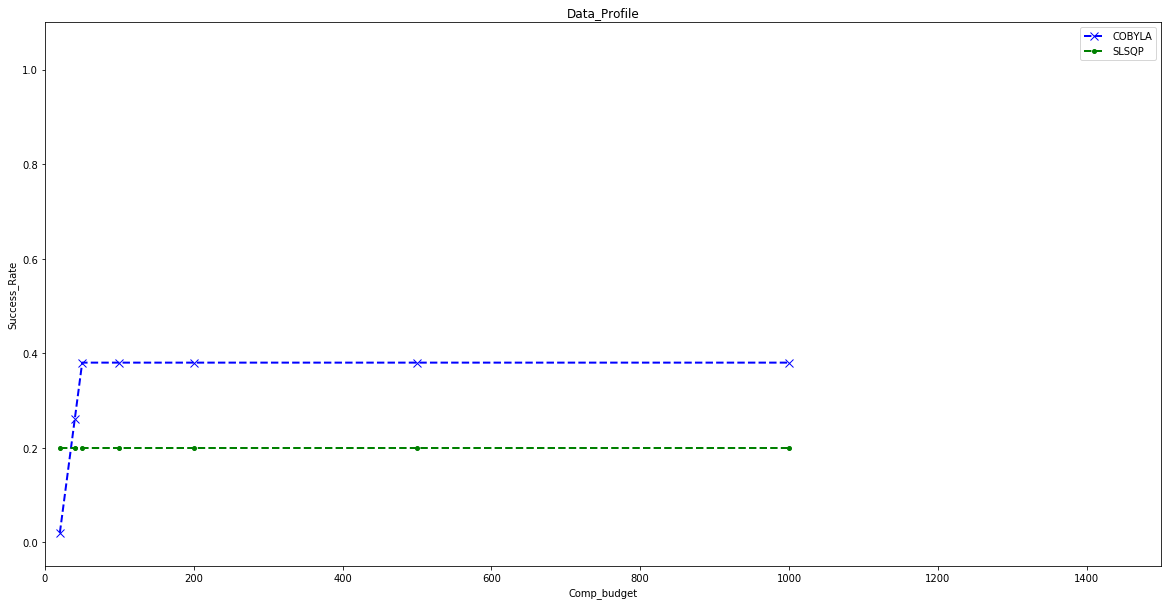

In [49]:
data_profile_application(great_table_app_0,color_vector=color_vector_1,marker_vector=marker_vector_1,algo_names=algo_names_app)

---
#  References
---

- Pardalos, Panos M.; Romeijn, Edwin H., "Handbook of Global Optimization", Springer Science and Business Media, 2013
- Liberti, Leo. “Introduction to Global Optimization.”, Computer Science, (2006)
- Ali, Montaz, Charoenchai Khompatraporn, and Zelda B. Zabinsky, “A Numerical
  Evaluation of Several Stochastic Algorithms on Selected Continuous Global Optimization
  Test Problems,” Journal of Global Optimization, 2005, 31, 635–672.
- Surjanovic, S. & Bingham, D. (2013). Virtual Library of Simulation Experiments: Test Functions and Datasets.     Retrieved January 4, 2022, from http://www.sfu.ca/~ssurjano.
- Jamil, M., & Yang, X. (2013). A literature survey of benchmark functions for global optimisation problems. Int. J. Math. Model. Numer. Optimisation, 4, 150-194.
- Griewank A.O. (1981), Generalized descent for global optimization,Journal of Optimization Theoryand Applications34, 11-39
- Locatelli, M. A Note on the Griewank Test Function. Journal of Global Optimization 25, 169–174 (2003). https://doi.org/10.1023/A:1021956306041
- Rosenbrock, H.H. (1960). "An automatic method for finding the greatest or least value of a function". The Computer Journal. 3 (3): 175–184. doi:10.1093/comjnl/3.3.175. ISSN 0010-4620.
- J. J. More', B. S. Garbow, and K. E. Hillstrom. Testing unconstrained optimization
   software. ACM Transactions on Mathematical Software (TOMS),7(1):17{41, March 1981
   
- Steven G. Johnson, The NLopt nonlinear-optimization package [link](http://github.com/stevengj/nlopt)
- Dolan, Elizabeth D. and Jorge Moré, “Benchmarking Optimization Software with Performance
  Profiles,” Mathematical Programming, 2002, 91 (2), 201–213.
- Moré, Jorge J. and Stefan M. Wild, “Benchmarking Derivative-Free Optimization Algorithms,”
  SIAM Journal on Optimization, 2009, 20 (1), 172–191.

- Price, Wyn L., “A controlled random search procedure for global optimisation,” The Computer
  Journal, 1977, 20 (4), 367–370.
  
- Kaelo, P. and M. M. Ali, “Some variants of the controlled random search algorithm for global
  optimization,” Journal of Optimization Theory and Applications, 2006, 130 (2), 253–264.
  
- Runarsson, Thomas P. and Xin Yao, “Stochastic ranking for constrained evolutionary
  optimization,” IEEE Transactions on evolutionary computation, 2000, 4 (3), 284–294.
  
- Rinnooy Kan, Alexander and G. T. Timmer, “Stochastic Global Optimization Methods,
  Part I, Clustering Methods,” Mathematic Programming, 1987, 39 (27-56).
  
- Silva-Santos, Carlos Henrique, Marcos Sergio Goncalves, and Hugo Enrique
  Hernandez-Figueroa, “Designing novel photonic devices by bio-inspired computing,” IEEE
  Photonics Technology Letters, 2010, 22 (15), 1177–1179.

- E. Atashpaz-Gargari and C. Lucas, "Imperialist competitive algorithm: An algorithm for optimization inspired by imperialistic competition," 2007 IEEE Congress on   
  Evolutionary Computation, 2007, pp. 4661-4667, doi: 10.1109/CEC.2007.4425083.

- Alberto Colorni, Marco Dorigo and Vittorio Maniezzo. "Distributed optimization by ant colonies." Proceedings of the first European conference on artificial life.    
  Vol.142. 1991
  
- Markowitz, H. (1952), PORTFOLIO SELECTION*. The Journal of Finance, 7: 77-91. https://doi.org/10.1111/j.1540-6261.1952.tb01525.x

- Eric Zivot Lecture Materials [see here](https://faculty.washington.edu/ezivot/classes.htm)

- Liu, Scott and Xu, Rong, The Effects of Risk Aversion on Optimization, February 2010 (February 22, 2010). MSCI Barra Research Paper No. 2010-06, Available at SSRN: https://ssrn.com/abstract=1601412 or http://dx.doi.org/10.2139/ssrn.1601412
